In [1]:
import numpy as np
import scipy as scp
from pyedflib import highlevel
import pyedflib as plib
import matplotlib.pyplot as plt
import mne as mne
from scipy import linalg as la
from sklearn.linear_model import Perceptron
import os

In [2]:
import os

def run_fast_scandir(dir, ext):    # dir: str, ext: list
    subfolders, datafiles = [], []

    for f in os.scandir(dir):
        if f.is_dir():
            subfolders.append(f.path)
        if f.is_file():
            if os.path.splitext(f.name)[1].lower() in ext:
                datafiles.append(f.path)

    for dir in list(subfolders):
        sf, f = run_fast_scandir(dir, ext)
        subfolders.extend(sf)
        datafiles.extend(f)
    return subfolders, datafiles


#subfolders, datafiles = run_fast_scandir('/content/drive/MyDrive/files', [".edf"])
subfolders, datafiles = run_fast_scandir('../dataset/files', [".edf"])
#subfolders, eventfiles = run_fast_scandir('/content/drive/MyDrive/files', [".event"])

subfolders.sort()
datafiles.sort()
print(subfolders[:3])
print(datafiles[:3])

['../dataset/files\\S001', '../dataset/files\\S002', '../dataset/files\\S003']
['../dataset/files\\S001\\S001R01.edf', '../dataset/files\\S001\\S001R02.edf', '../dataset/files\\S001\\S001R03.edf']


<h1>Criação do filter bank - próximos 2 blocos</h1>

In [3]:
min_freq = 4
max_freq = 40

n_bands = int((max_freq - min_freq)/2)

bands = []
f1 = 4
f2 = 8

for i in range(1,n_bands):
  bands.append([f1,f2])
  f1+=2
  f2+=2
print("Bandas de frequência: ", bands)

Bandas de frequência:  [[4, 8], [6, 10], [8, 12], [10, 14], [12, 16], [14, 18], [16, 20], [18, 22], [20, 24], [22, 26], [24, 28], [26, 30], [28, 32], [30, 34], [32, 36], [34, 38], [36, 40]]


In [4]:
mne.set_log_level('INFO') #  Suprimir os logs das funções da biblioteca/ it can be either DEBUG, INFO, WARNING, ERROR, or CRITICAL

filter_design = 'firwin2'
ska = 'edge'

raw = mne.io.read_raw_edf(datafiles[0], preload = False)
channels = raw.ch_names
n_channels = len(channels)

for band in bands:

  filter_params = mne.filter.create_filter(raw.get_data(), raw.info['sfreq'],l_freq=band[0], h_freq=band[1], fir_design = filter_design) # Criar filtro. É preciso dados como parâmetro
  #mne.viz.plot_filter(filter_params, raw.info['sfreq'], flim=(0.5, 60)) # Plot do filtro

mne.set_log_level('WARNING')

Extracting EDF parameters from c:\Users\tomas\Desktop\Trabalho\FEUP\Neuro\Project\eegaming\dataset\files\S001\S001R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 529 samples (3.306 s)

Setting up band-pass filter from 6 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Lower passband edge: 6.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Upper pass

In [5]:
def check_event_count(event_data):

  '''
  Função que:
  - Faz prints do número de trials/blocos de cada classe de movimento. 

  ---------------------
  Input:
  - event_data: Objeto com todos os blocos de dados

  '''

  print("Rest: ", event_data["rest"].__len__())
  print("Right Fist: ", event_data["right_fist"].__len__())
  print("Left Fist: ", event_data["left_fist"].__len__())
  print("Both Fists: ", event_data["both_fists"].__len__())
  print("Both Feet: ", event_data["both_feet"].__len__())
     

''' Commit "Test/Train split: 84144ec" tem todo o código com os prints e plots desta função relacionados com os eventos'''

def load_subject_data(subject, datafiles, bands, tstart, tstop):

  '''
  Função que:
  - Carrega todos os dados contínuos de um participante da base de dados.
  - Filtra os dados contínuos.
  - Reatribui as labels para separar melhor as 5 classes de EEG da base de dados.
  - Agrupa e concatena os blocos dados dos vários trials (bloco com cerca de 4.2s de dados que 
  corresponde à execução de uma classe de movimento) de ficheiros 
  diferentes a partir das novas labels.
  - Segmenta os dados 

  ---------------------
  Input:
  subject: Caminho para o diretório onde estão todos os ficheiros de um participante 
  datafiles: Caminhos de todos os ficheiros edf (todos os participantes) da base de dados
  tstart: Instante no tempo (s) da primeira amostra do segmento de um bloco a ser analisado
  tstop: Instante no tempo (s) da última amostra do segmento de um bloco a ser analisado
  
  ---------------------
  Output:
  subject_epochs: Objeto com todos os blocos de dados concatenados e com toda a informção relativamente
  aos eventos de cada classe
  '''

  trials = []
  for trial in datafiles: 
    if subject in trial: 
      trials.append(trial)

  eachBand_epochs = []
  
  for band in bands: # Filtrar os dados nas várias bandas de frequência
    print(f"Filtragem na banda de frequências: {band[0]} - {band[1]} Hz")

    all_trials = [] # Variável com todos os blocos
    
    for count, trial  in enumerate(trials):
      if count > 1: # Avança os dois primeiros trials correspondentes ao rest
        raw_data = mne.io.read_raw_edf(trial, preload = True) # Dados EEG para um trial específico. 'Preload=True' serve para colocar o ficheiro na memória e não apenas referenciá-lo no diretório
        
        ch_names = raw_data.ch_names # Elétrodos
        fs =  raw_data.info.get('sfreq') # Frequência de amostragem
        annotations = raw_data.annotations # Variável que contém os dados no tempo relativos aos blocos de movimentos executados

        trial_type1 = [3, 4, 7, 8, 11, 12]
        trial_type2 = [5, 6, 9, 10, 13, 14]

        # Atribuição das labels corretas aos eventos de cada trial
        #--------------- TOMÁS: tive de adaptar a linha seguinte por causa da maneira como tenho o diretório (../ yada yada, cria uma separação para cada ponto,
        # então fica algo tipo [''] [''] ['actual diretorio'] ['edf']) -----------------------------------------
        trial_number = int(trial.split('.')[2][-2:]) # De 1 a 14; [0] corresponde à primeira parte da string original;
        
        if trial_number in trial_type1:
          event_ids = {'T0': 1, 'T1': 2, 'T2': 3} # Dicionário com os ids dos eventos de acordo com a descrição a laranja ^^
          epoch_event_ids = {"rest/block": 1, "left_fist/block": 2, "right_fist/block": 3}
        elif trial_number in trial_type2:
          event_ids = {'T0': 1, 'T1': 4, 'T2': 5}
          epoch_event_ids = {"rest/block": 1, "both_fists/block": 4,"both_feet/block": 5}
        else:
          event_ids = {'T0': 1} # Dois primeiros trials de EEG

        # Filtragem

        filtered_data = raw_data.copy().filter(band[0], band[1], fir_design=filter_design, skip_by_annotation=ska) 
        
        # Mapeamento dos eventos com as novas labels

        events = mne.events_from_annotations(filtered_data, event_id = event_ids) # Variável eventos: Retorna 3 colunas [Indice da amostra onde começa o bloco, Trigger, Tipo de movimento (label)]
        
        # Agrupamento dos blocos do mesmo id (epoching)

        epochs = mne.Epochs(filtered_data, events[0], event_id = epoch_event_ids, tmin = tstart, tmax = tstop, detrend = 1, baseline = None, preload = True)
        
        all_trials.append(epochs)
        
    # Concatenação de todos os blocos (trials) de uma banda de frequências

    subject_epochs = mne.concatenate_epochs(all_trials, add_offset = True, on_mismatch = 'raise')
    equalized_subject_epochs = subject_epochs.equalize_event_counts()[0]

    eachBand_epochs.append(equalized_subject_epochs)
    
  return eachBand_epochs

In [6]:
# Carregar dados de todos os participantes
# Equaliza o nº de trials em todas as classes. A classe rest tinha muitos mais trials por exemplo.
# O bom balanceamento de classes é importante durante a classificação

mne.set_log_level('CRITICAL')

all_subject_epochs = []

for id, subject in enumerate([subfolders[0]]):
  print("---------------------------------------------")
  print("Ler dados do participante: ", id+1)
  all_subject_epochs.append(load_subject_data(subject, datafiles, bands, 0.5, 3))

mne.set_log_level('WARNING')

---------------------------------------------
Ler dados do participante:  1
Filtragem na banda de frequências: 4 - 8 Hz
Filtragem na banda de frequências: 6 - 10 Hz
Filtragem na banda de frequências: 8 - 12 Hz
Filtragem na banda de frequências: 10 - 14 Hz
Filtragem na banda de frequências: 12 - 16 Hz
Filtragem na banda de frequências: 14 - 18 Hz
Filtragem na banda de frequências: 16 - 20 Hz
Filtragem na banda de frequências: 18 - 22 Hz
Filtragem na banda de frequências: 20 - 24 Hz
Filtragem na banda de frequências: 22 - 26 Hz
Filtragem na banda de frequências: 24 - 28 Hz
Filtragem na banda de frequências: 26 - 30 Hz
Filtragem na banda de frequências: 28 - 32 Hz
Filtragem na banda de frequências: 30 - 34 Hz
Filtragem na banda de frequências: 32 - 36 Hz
Filtragem na banda de frequências: 34 - 38 Hz
Filtragem na banda de frequências: 36 - 40 Hz


<h1>Exemplo de handling destes dados

In [7]:
subject_epochs = all_subject_epochs[0][0]

print("\nEqualização de eventos: ")
check_event_count(subject_epochs)
print("\n")

# Seleção de elétrodos
print(channels)
chan = mne.pick_channels(channels, include = ['F3..', 'Fz..','F4..', 
                                              'Fc3.', 'Fcz.','Fc4.',
                                                'C3..','Cz..','C4..',
                                                'Cp3.', 'Cpz.', 'Cp4.',
                                                'P3..', 'Pz..', 'P4..',
                                                'Oz..' ])
print("Indices: ", chan)

#dir(subject_epochs)
print("Condições: ",subject_epochs.event_id)
print("\nBlocos: ",subject_epochs.events)
subject_epochs["right_fist"].plot_image(picks=[chan[0]])


Equalização de eventos: 
Rest:  44
Right Fist:  44
Left Fist:  44
Both Fists:  44
Both Feet:  44


['Fc5.', 'Fc3.', 'Fc1.', 'Fcz.', 'Fc2.', 'Fc4.', 'Fc6.', 'C5..', 'C3..', 'C1..', 'Cz..', 'C2..', 'C4..', 'C6..', 'Cp5.', 'Cp3.', 'Cp1.', 'Cpz.', 'Cp2.', 'Cp4.', 'Cp6.', 'Fp1.', 'Fpz.', 'Fp2.', 'Af7.', 'Af3.', 'Afz.', 'Af4.', 'Af8.', 'F7..', 'F5..', 'F3..', 'F1..', 'Fz..', 'F2..', 'F4..', 'F6..', 'F8..', 'Ft7.', 'Ft8.', 'T7..', 'T8..', 'T9..', 'T10.', 'Tp7.', 'Tp8.', 'P7..', 'P5..', 'P3..', 'P1..', 'Pz..', 'P2..', 'P4..', 'P6..', 'P8..', 'Po7.', 'Po3.', 'Poz.', 'Po4.', 'Po8.', 'O1..', 'Oz..', 'O2..', 'Iz..']
Indices:  [31 33 35  1  3  5  8 10 12 15 17 19 48 50 52 61]
Condições:  {'rest/block': 1, 'left_fist/block': 2, 'right_fist/block': 3, 'both_fists/block': 4, 'both_feet/block': 5}

Blocos:  [[   672      0      3]
 [  1328      0      1]
 [  2000      0      2]
 [  3328      0      2]
 [  4656      0      3]
 [  5312      0      1]
 [  5984      0      3]
 [  6640      0      1]
 [  7

C:\Users\tomas\AppData\Local\Temp\ipykernel_15812\2909259823.py:20: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  subject_epochs["right_fist"].plot_image(picks=[chan[0]])


[<Figure size 640x480 with 3 Axes>]

<h2> Função que vem a seguir, antes do csp, avalia se achas necessario/ se da jeito

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
def split_EEG(subject_EEG, classes, percent_train=0.8):
  
  n_trials, _, _ = np.shape(subject_EEG)
  n_train = round((n_trials/len(classes)) * percent_train)
  n_test = int((n_trials/len(classes)) - n_train)

  # print("Nº de trials: ", n_trials)
  # print("Nº de trials para treinar (por classe): ", n_train)
  # print("Nº de trials para teste (por classe): ", n_test)

  epochs_train = []
  epochs_test = []

  #shuffle trials. O miguel nao fazia. N sei se é sposto n fazer. o on missmatch com raise avisa que n esta por ordem cronologica
  np.random.seed(42)
  ids = np.random.permutation(n_trials//len(classes))
  ids_train = ids[:n_train]
  ids_test = ids[n_train:n_train+n_test]

  for class_key, _ in classes.items():
    epochs_train.append(subject_EEG[class_key][ids_train]._data)
    epochs_test.append(subject_EEG[class_key][ids_test]._data)

  #conver to numpy array
  epochs_train = np.array(epochs_train)
  epochs_test = np.array(epochs_test)

  #filter only channels of interest
  epochs_train = epochs_train[:, :, chan, :]
  epochs_test = epochs_test[:, :, chan, :]
  
  print("Shape dos dados de treino: ", epochs_train.shape)
  print("Shape dos dados de teste: ", epochs_test.shape)

  return epochs_train, epochs_test

# Split Test/Train

classes = subject_epochs.event_id

all_train_data = []
all_test_data = []

#for subject in range(len(all_subject_epochs)):
for subject in [0]:

  bands_train_data = []
  bands_test_data = []
  print("Sujeito: ", subject+1)

  for band in range(len(bands)):
    train_data, test_data = split_EEG(all_subject_epochs[subject][band], classes, percent_train=0.8)
    bands_train_data.append(train_data)
    bands_test_data.append(test_data)

  all_train_data.append(bands_train_data)
  all_test_data.append(bands_test_data)

all_train_data = np.array(all_train_data)
all_test_data = np.array(all_test_data)

print("Shape dos dados de treino: ", all_train_data.shape)
print("Shape dos dados de teste: ", all_test_data.shape)

Sujeito:  1
Shape dos dados de treino:  (5, 35, 16, 401)
Shape dos dados de teste:  (5, 9, 16, 401)
Shape dos dados de treino:  (5, 35, 16, 401)
Shape dos dados de teste:  (5, 9, 16, 401)
Shape dos dados de treino:  (5, 35, 16, 401)
Shape dos dados de teste:  (5, 9, 16, 401)
Shape dos dados de treino:  (5, 35, 16, 401)
Shape dos dados de teste:  (5, 9, 16, 401)
Shape dos dados de treino:  (5, 35, 16, 401)
Shape dos dados de teste:  (5, 9, 16, 401)
Shape dos dados de treino:  (5, 35, 16, 401)
Shape dos dados de teste:  (5, 9, 16, 401)
Shape dos dados de treino:  (5, 35, 16, 401)
Shape dos dados de teste:  (5, 9, 16, 401)
Shape dos dados de treino:  (5, 35, 16, 401)
Shape dos dados de teste:  (5, 9, 16, 401)
Shape dos dados de treino:  (5, 35, 16, 401)
Shape dos dados de teste:  (5, 9, 16, 401)
Shape dos dados de treino:  (5, 35, 16, 401)
Shape dos dados de teste:  (5, 9, 16, 401)
Shape dos dados de treino:  (5, 35, 16, 401)
Shape dos dados de teste:  (5, 9, 16, 401)
Shape dos dados de t

Sujeito:  1
Banda:  1


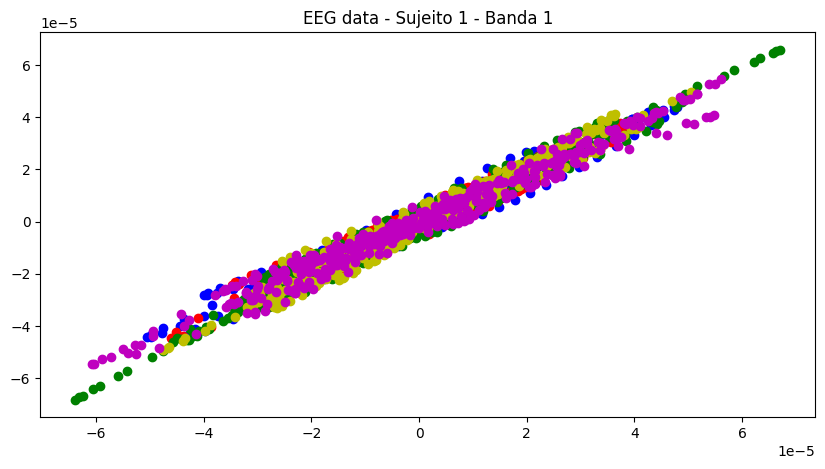

Banda:  2


Banda:  3


Banda:  4


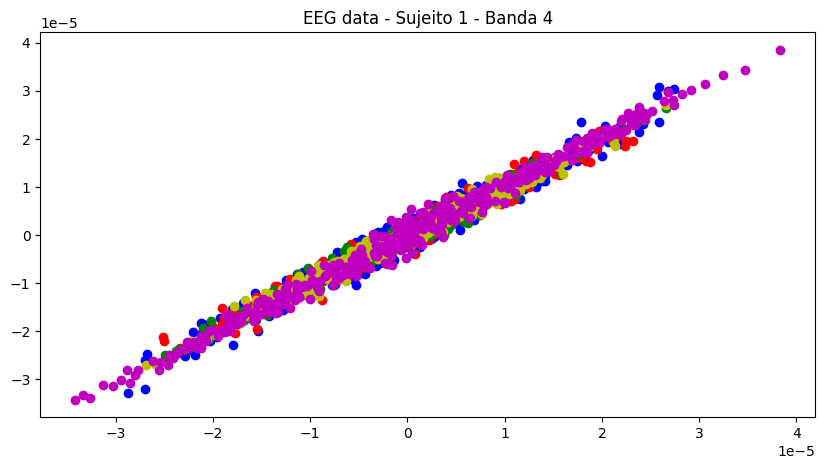

Banda:  5


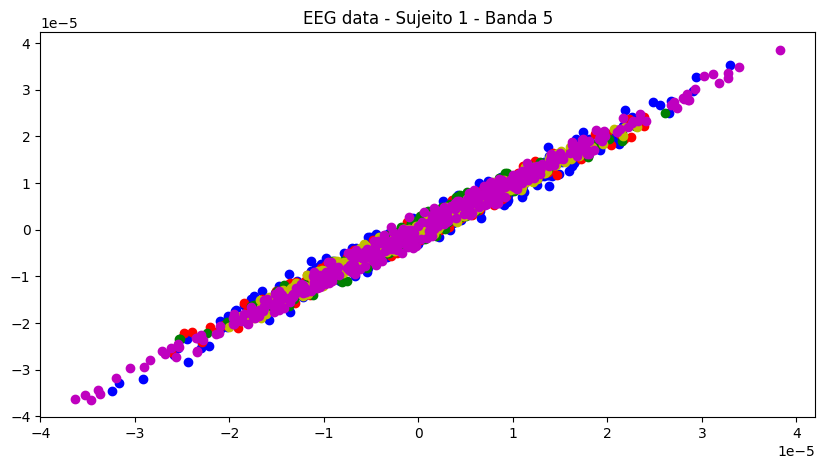

Banda:  6


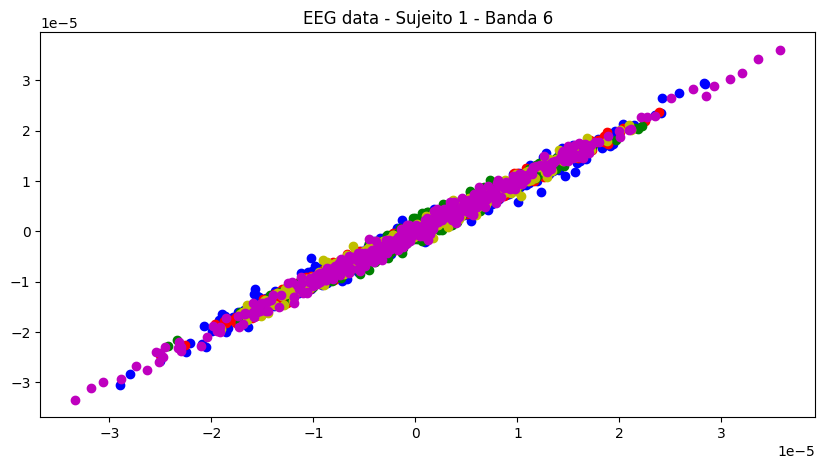

Banda:  7


Banda:  8


Banda:  9


Banda:  10


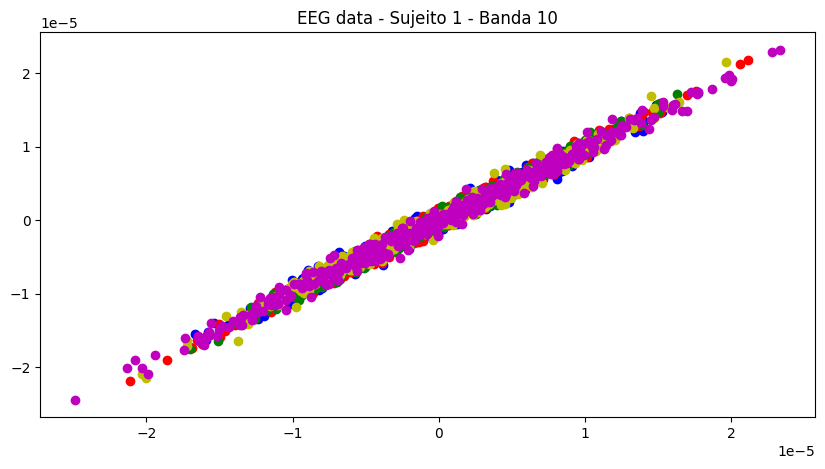

Banda:  11


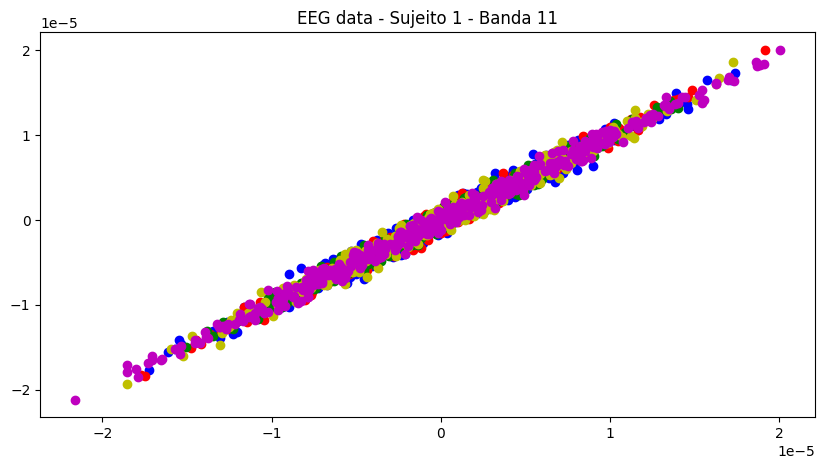

Banda:  12


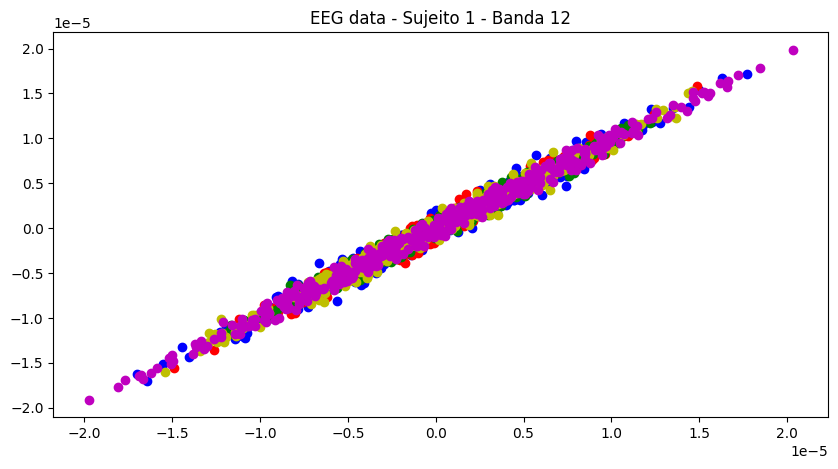

Banda:  13


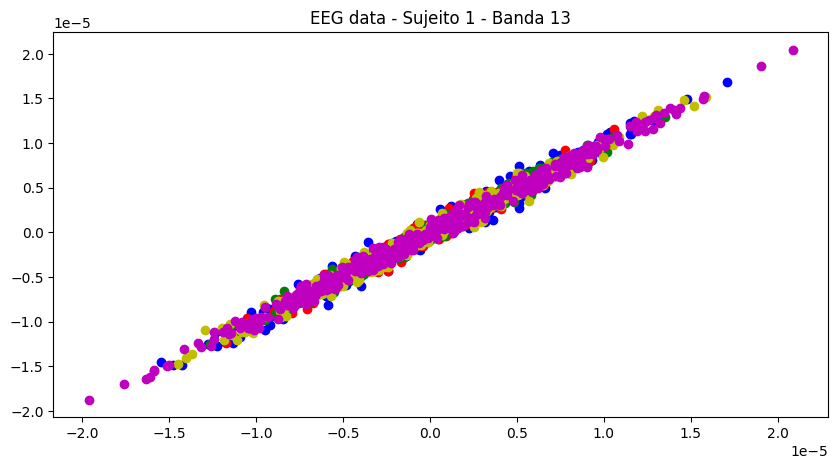

Banda:  14


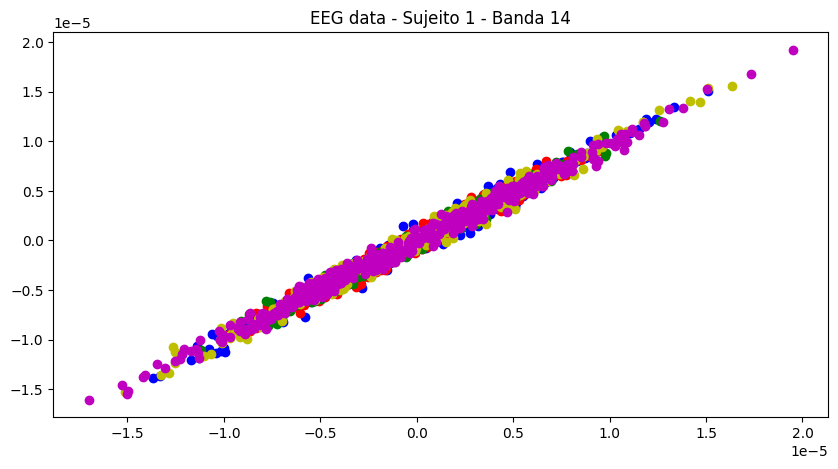

Banda:  15


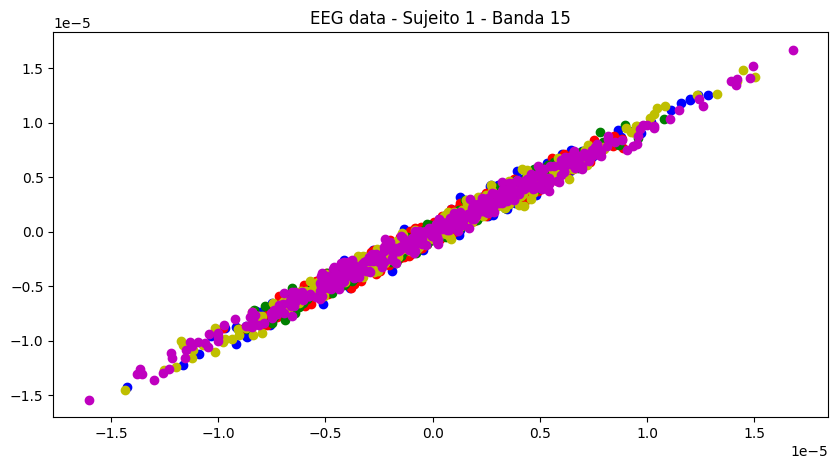

Banda:  16


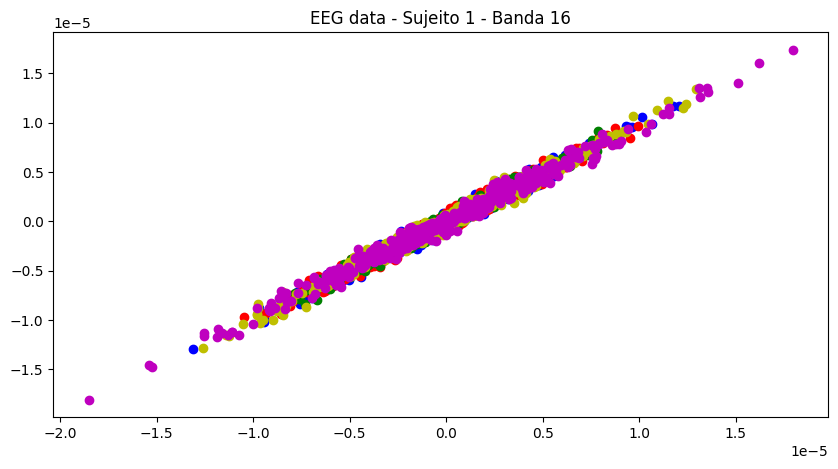

Banda:  17


In [10]:
import matplotlib.pyplot as plt
colors = ['b', 'r', 'g', 'y', 'm']

subject = 0
print("Sujeito: ", subject+1)

for band in range(len(bands)):
    print("Banda: ", band+1)
    plt.figure(figsize=(10, 5))
    for class_ in range(5):
        # for i in range(all_train_data[subject][band][0][0].shape[0]): 
        #     plt.plot(all_train_data[subject][band][0][0][i])
        plt.scatter(all_train_data[subject][band][class_][0][0], all_train_data[subject][band][class_][0][2], color = colors[class_])
    plt.title(f"EEG data - Sujeito {subject+1} - Banda {band+1}")
    plt.show()



In [11]:
def train_CSP(X, Y, num_filters):

    num_classes = len(np.unique(Y))

    covariances = []
    for i in range(num_classes):
        X_class = X[Y == i]
        S_class = np.mean([np.matmul(X_class[j], X_class[j].T) for j in range(X_class.shape[0])], axis=0)
        covariances.append(S_class)

    S0 = covariances[0]
    S1 = covariances[1]

    d, V = la.eigh(S0, S0 + S1)

    # get order of eigenvalues
    idx = np.argsort(np.abs(d - 0.5))[::-1]

    # reorder the eigenvectors
    V = V[:, idx]

    # transpose
    W = V.T

    # compute the patterns
    pattern = np.linalg.pinv(V)

    #select the two most important filters
    W = W[: num_filters]

    return W


def apply_csp(X, W, mean_power=False):
    X_csp = np.asarray([np.dot(W, epoch) for epoch in X])
    if mean_power:
        X_csp = (X_csp**2).mean(axis=2)
    
    return X_csp

In [12]:
from sklearn.linear_model import LogisticRegression


def fit_model(X, y, balance_classes=False):
    mean_dataset = np.mean(X, axis=(2))
    cov_dataset = np.array([np.cov(trial) for trial in X])

    dataset = np.array([[cov_dataset[i][0][1]/cov_dataset[i][0][0], cov_dataset[i][1][1]/cov_dataset[i][0][0]] for i in range(X.shape[0])])

    if balance_classes:
        from imblearn.over_sampling import SMOTE
        sm = SMOTE(random_state=42)
        dataset, y = sm.fit_resample(dataset, y)

    clf = LogisticRegression(random_state=0).fit(dataset, y)

    return clf

def infer_model(clf, X):
    mean_dataset = np.mean(X, axis=(2))
    cov_dataset = np.array([np.cov(trial) for trial in X])

    dataset = np.array([[cov_dataset[i][0][1]/cov_dataset[i][0][0], cov_dataset[i][1][1]/cov_dataset[i][0][0]] for i in range(X.shape[0])])

    return clf.predict(dataset)

def test_model(clf, X, Y):
    mean_dataset = np.mean(X, axis=(2))
    cov_dataset = np.array([np.cov(trial) for trial in X])

    dataset = np.array([[cov_dataset[i][0][1]/cov_dataset[i][0][0], cov_dataset[i][1][1]/cov_dataset[i][0][0]] for i in range(X.shape[0])])

    return clf.score(dataset, Y)

(17, 5, 35, 16, 401)
(17, 175, 16, 401)
(175, 16, 401)
Classification Acc: 0.6571428571428571


(175, 16, 401)
Classification Acc: 0.5428571428571428


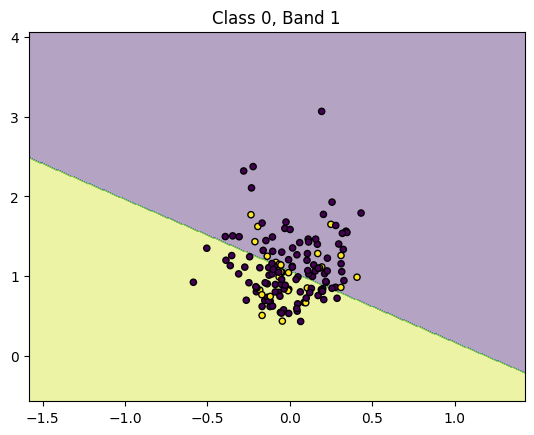

(175, 16, 401)
Classification Acc: 0.4


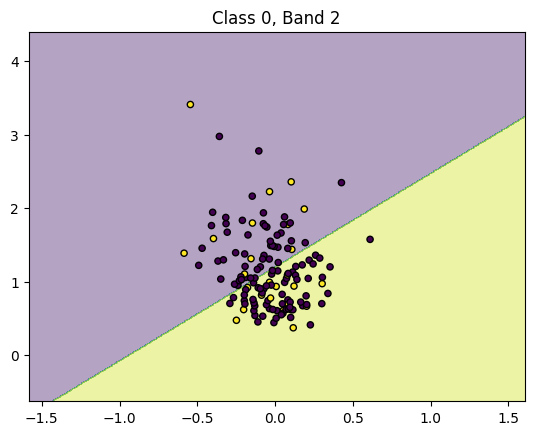

(175, 16, 401)
Classification Acc: 0.6571428571428571


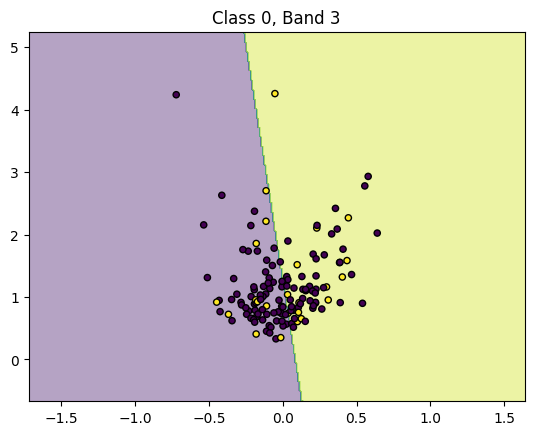

(175, 16, 401)
Classification Acc: 0.5714285714285714


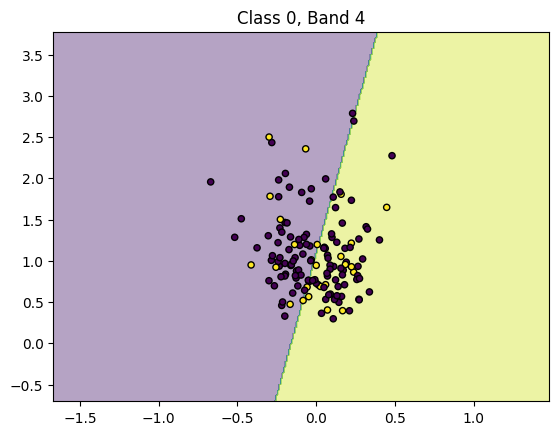

(175, 16, 401)
Classification Acc: 0.3142857142857143


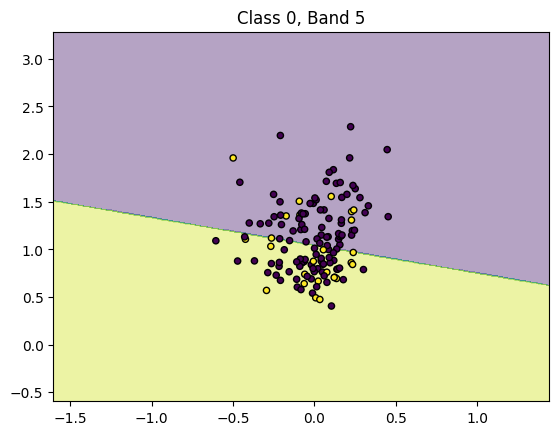

(175, 16, 401)
Classification Acc: 0.45714285714285713


(175, 16, 401)
Classification Acc: 0.4857142857142857


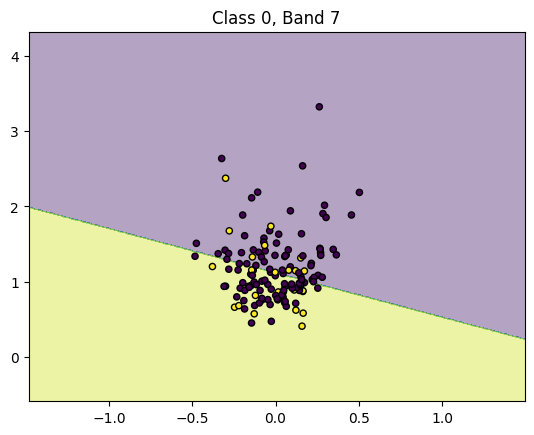

(175, 16, 401)
Classification Acc: 0.5428571428571428


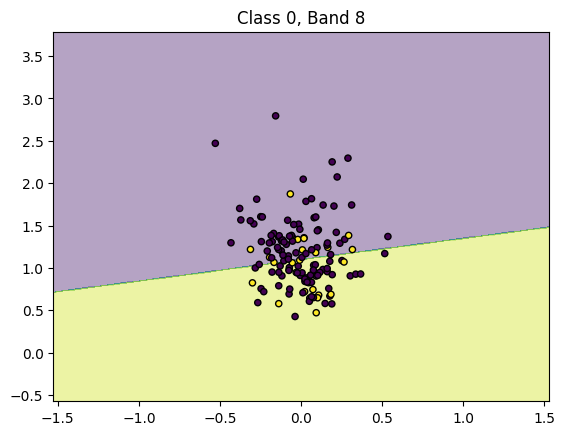

(175, 16, 401)
Classification Acc: 0.6


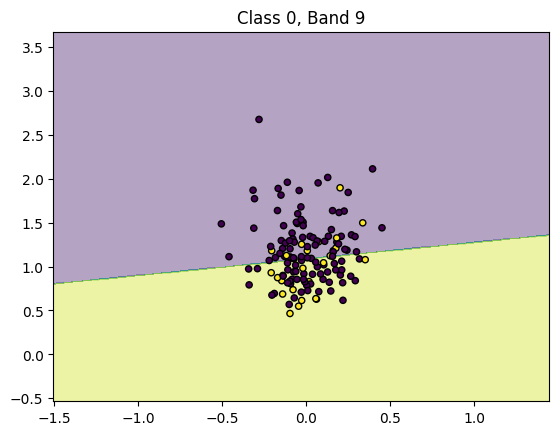

(175, 16, 401)
Classification Acc: 0.7142857142857143


(175, 16, 401)
Classification Acc: 0.7142857142857143


(175, 16, 401)
Classification Acc: 0.6


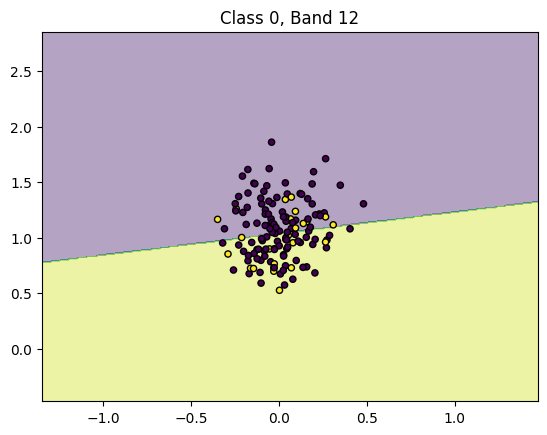

(175, 16, 401)
Classification Acc: 0.8857142857142857


(175, 16, 401)
Classification Acc: 0.8285714285714286


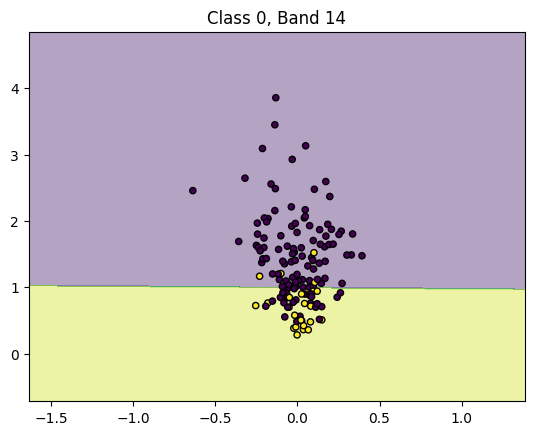

(175, 16, 401)
Classification Acc: 0.8571428571428571


(175, 16, 401)
Classification Acc: 0.8285714285714286


(175, 16, 401)
Classification Acc: 0.6


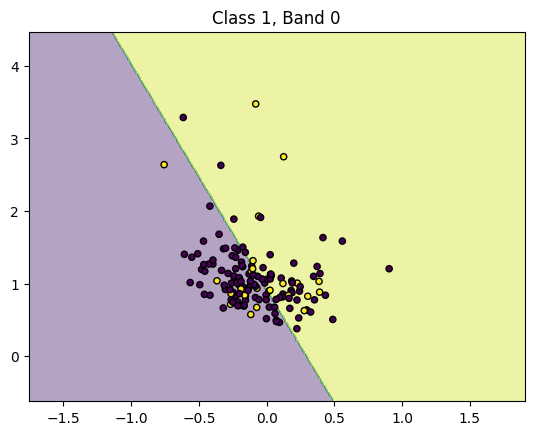

(175, 16, 401)
Classification Acc: 0.5714285714285714


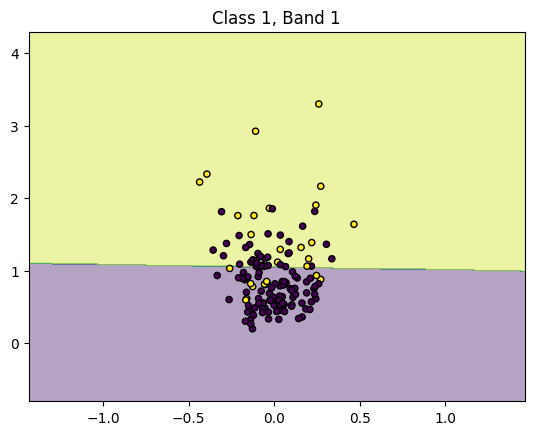

(175, 16, 401)
Classification Acc: 0.6


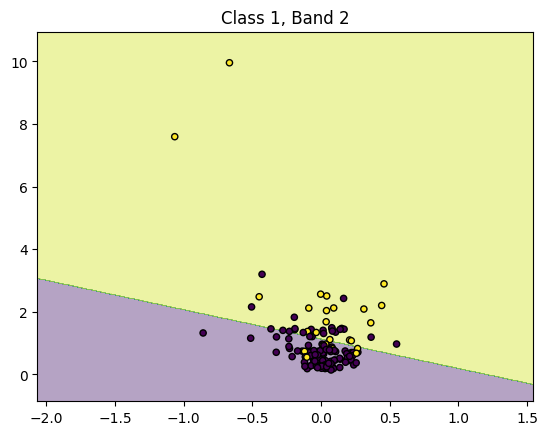

(175, 16, 401)
Classification Acc: 0.6857142857142857


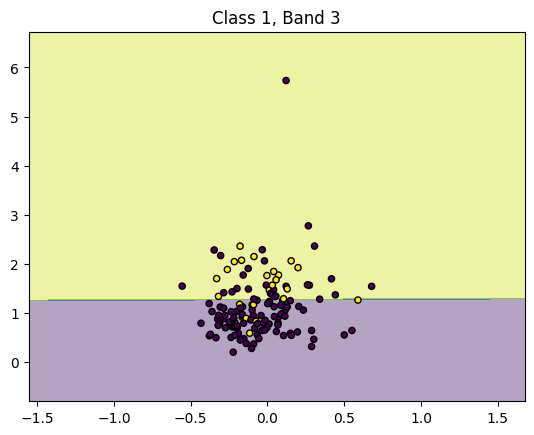

(175, 16, 401)
Classification Acc: 0.6285714285714286


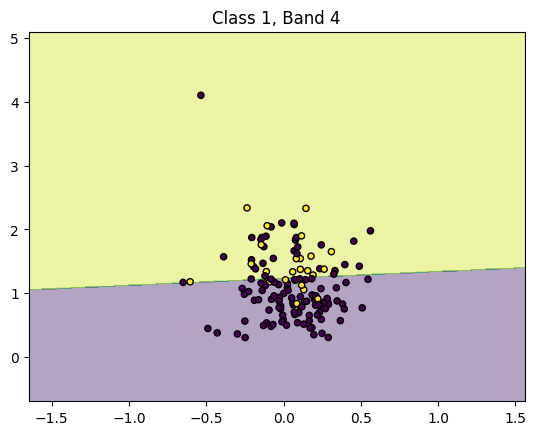

(175, 16, 401)
Classification Acc: 0.6571428571428571


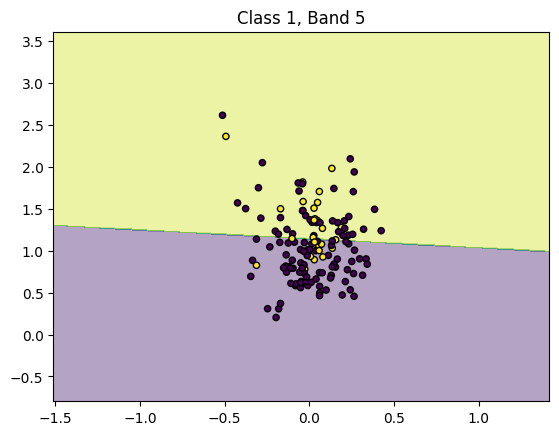

(175, 16, 401)
Classification Acc: 0.8


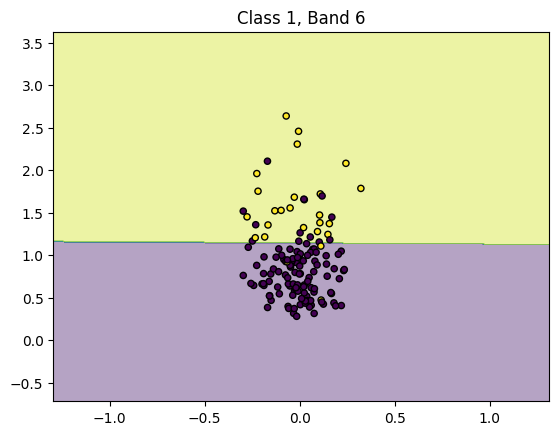

(175, 16, 401)
Classification Acc: 0.6


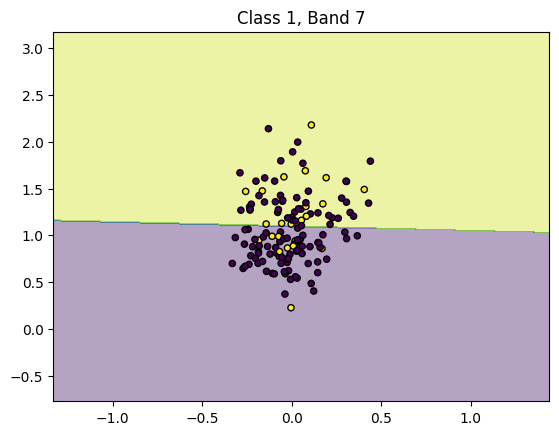

(175, 16, 401)
Classification Acc: 0.5142857142857142


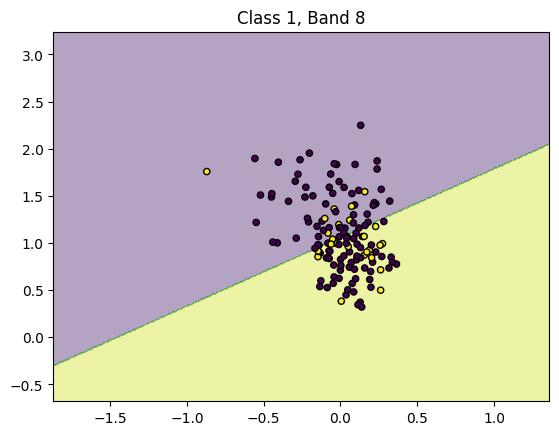

(175, 16, 401)
Classification Acc: 0.45714285714285713


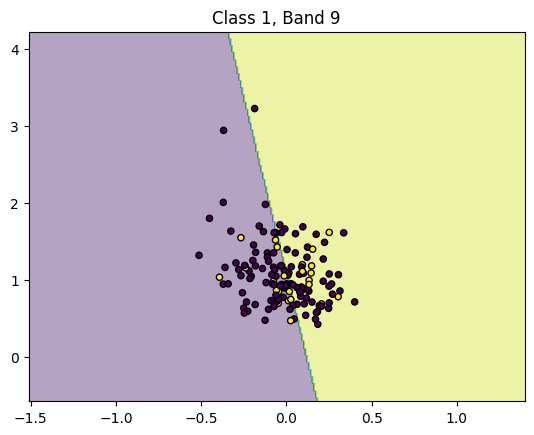

(175, 16, 401)
Classification Acc: 0.42857142857142855


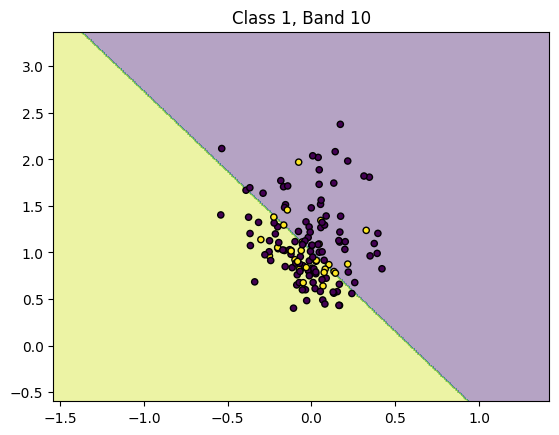

(175, 16, 401)
Classification Acc: 0.5428571428571428


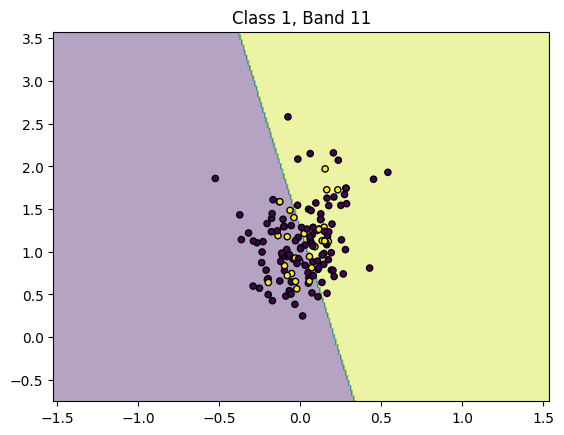

(175, 16, 401)
Classification Acc: 0.5428571428571428


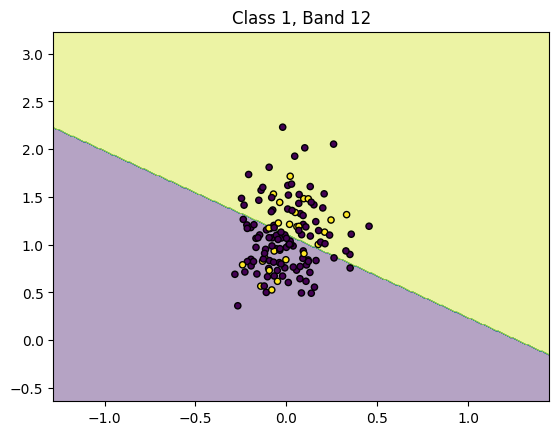

(175, 16, 401)
Classification Acc: 0.6


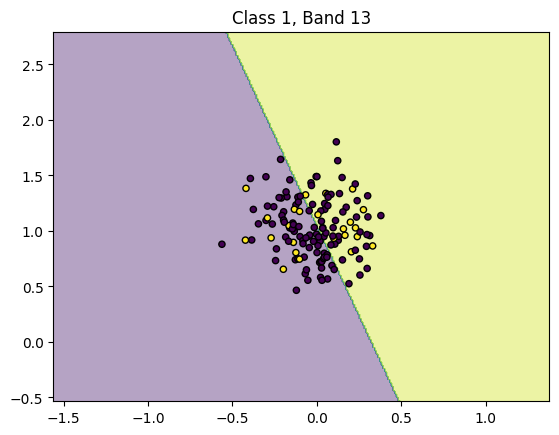

(175, 16, 401)
Classification Acc: 0.4


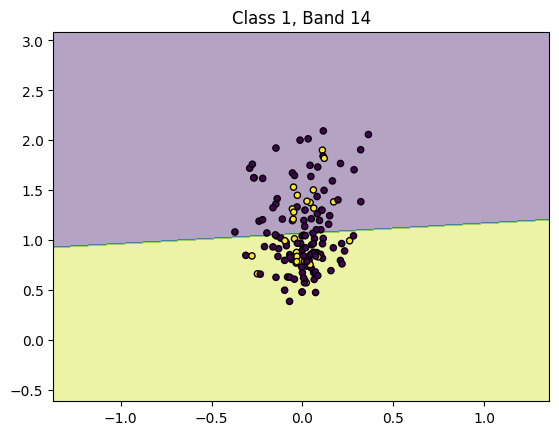

(175, 16, 401)
Classification Acc: 0.42857142857142855


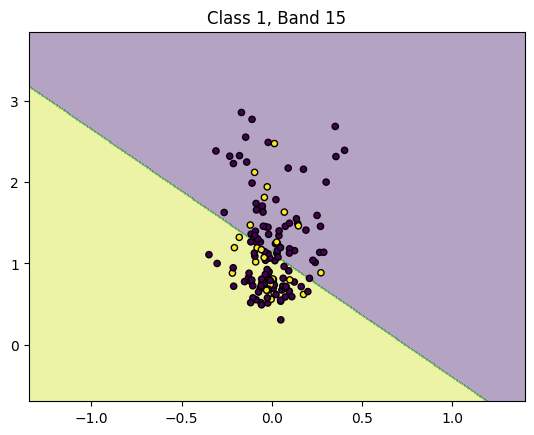

(175, 16, 401)
Classification Acc: 0.4


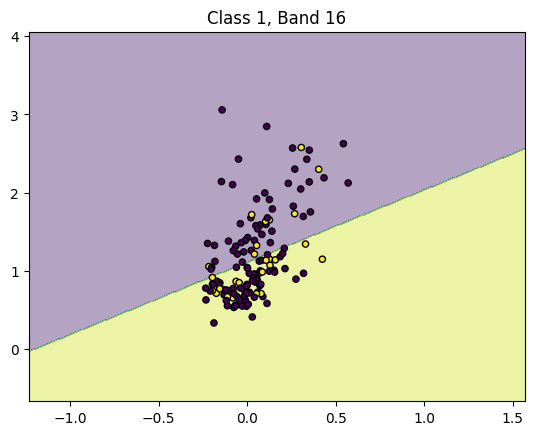

(175, 16, 401)
Classification Acc: 0.6


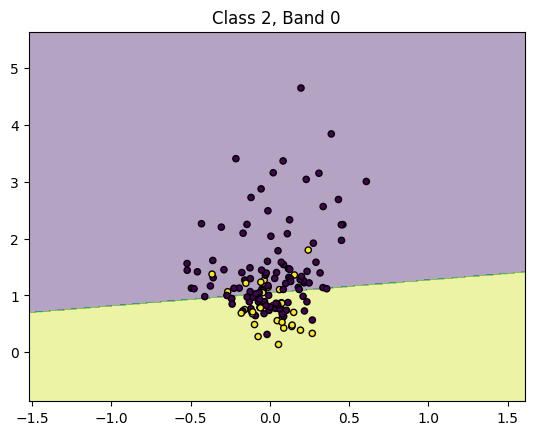

(175, 16, 401)
Classification Acc: 0.7142857142857143


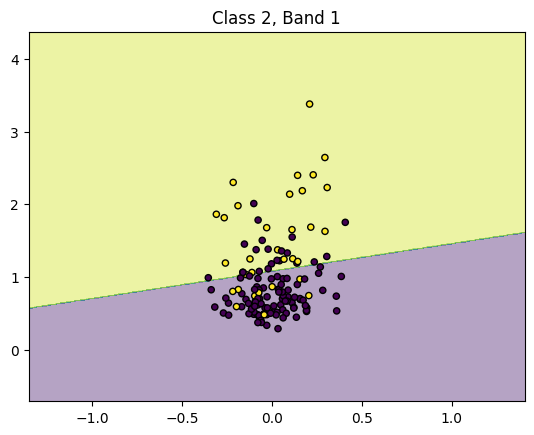

(175, 16, 401)
Classification Acc: 0.5428571428571428


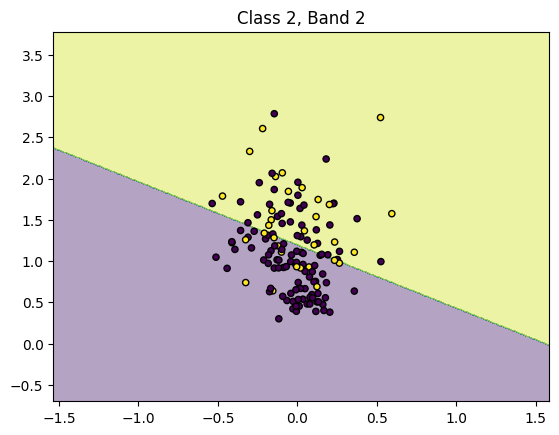

(175, 16, 401)
Classification Acc: 0.6


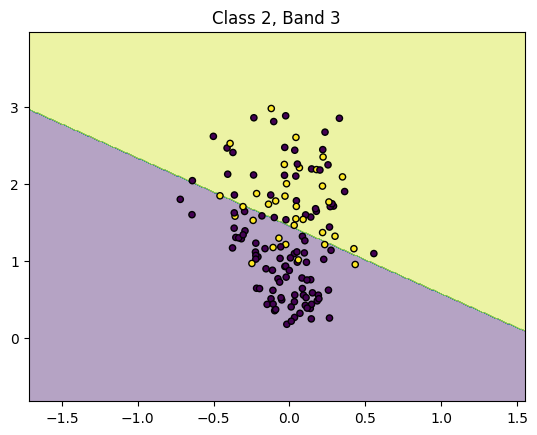

(175, 16, 401)
Classification Acc: 0.6


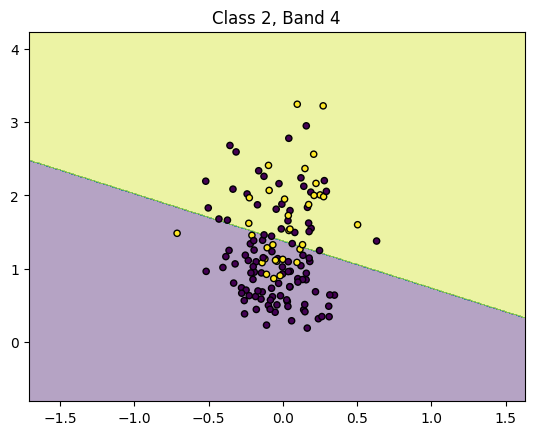

(175, 16, 401)
Classification Acc: 0.6


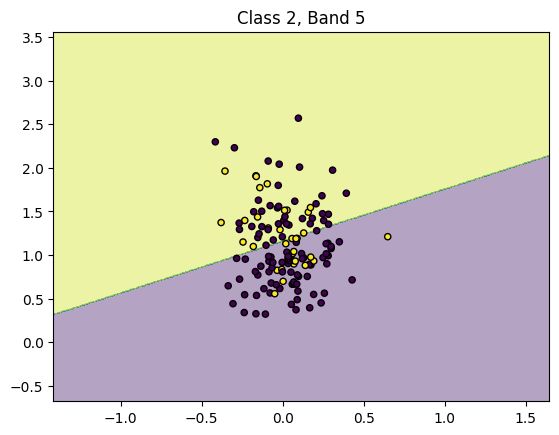

(175, 16, 401)
Classification Acc: 0.4857142857142857


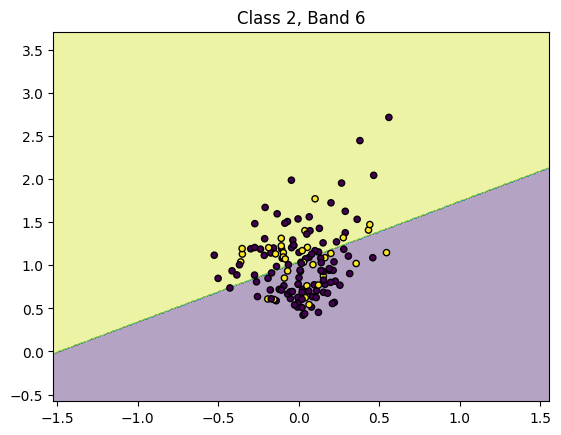

(175, 16, 401)
Classification Acc: 0.6857142857142857


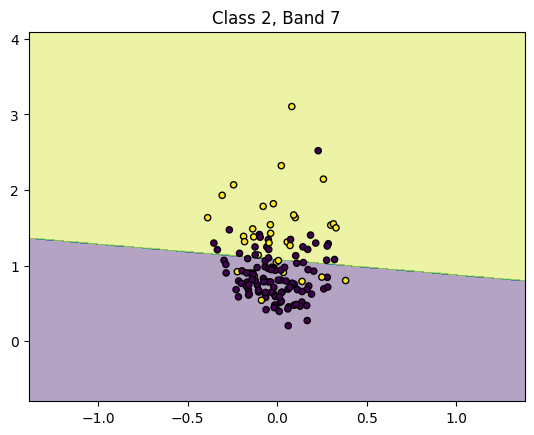

(175, 16, 401)
Classification Acc: 0.5714285714285714


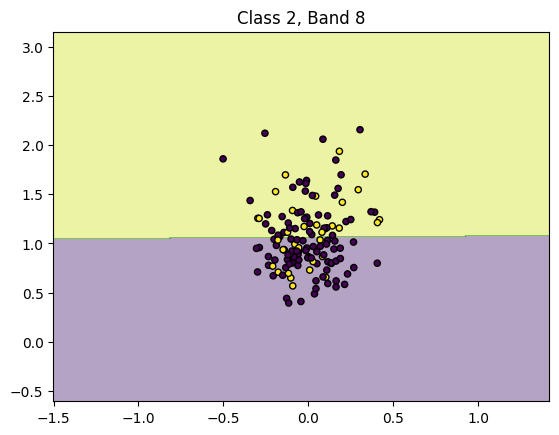

(175, 16, 401)
Classification Acc: 0.5142857142857142


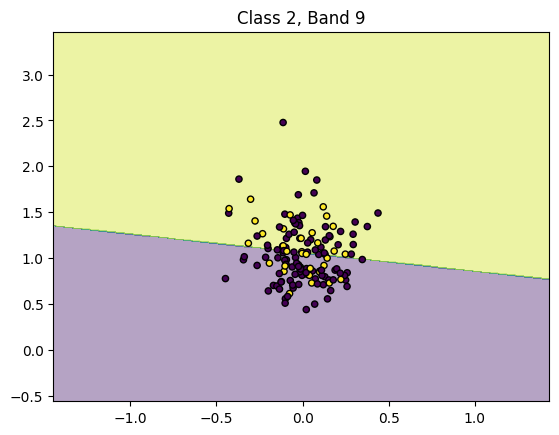

(175, 16, 401)
Classification Acc: 0.7142857142857143


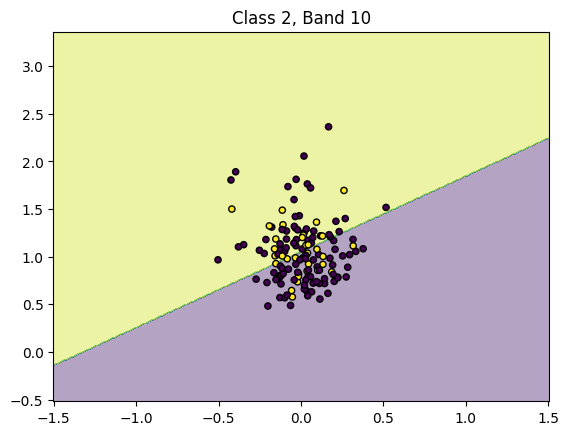

(175, 16, 401)
Classification Acc: 0.7714285714285715


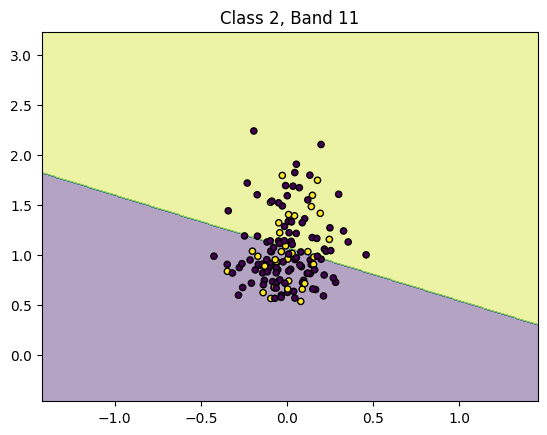

(175, 16, 401)
Classification Acc: 0.5714285714285714


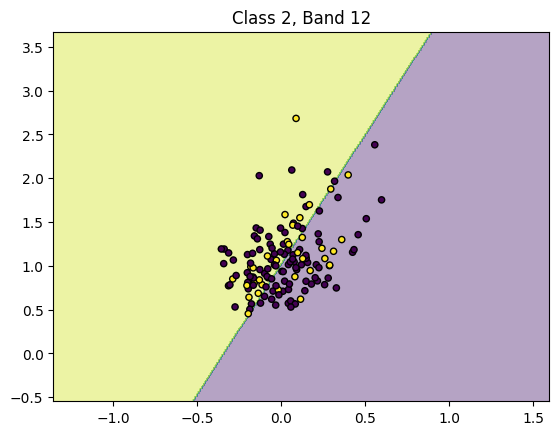

(175, 16, 401)
Classification Acc: 0.6


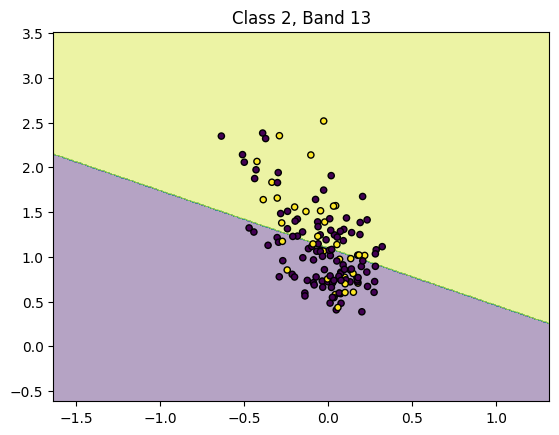

(175, 16, 401)
Classification Acc: 0.6571428571428571


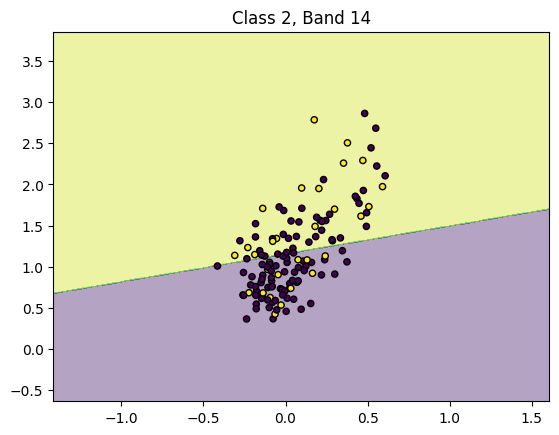

(175, 16, 401)
Classification Acc: 0.6571428571428571


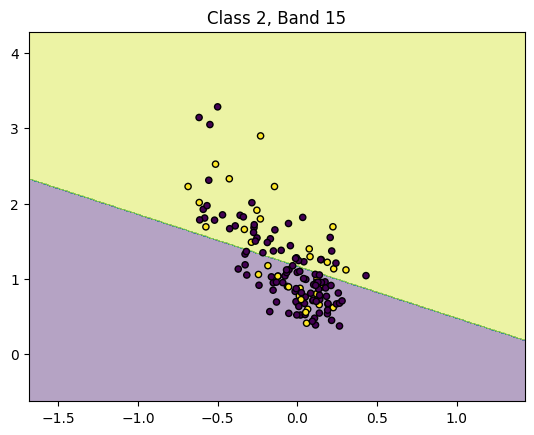

(175, 16, 401)
Classification Acc: 0.6857142857142857


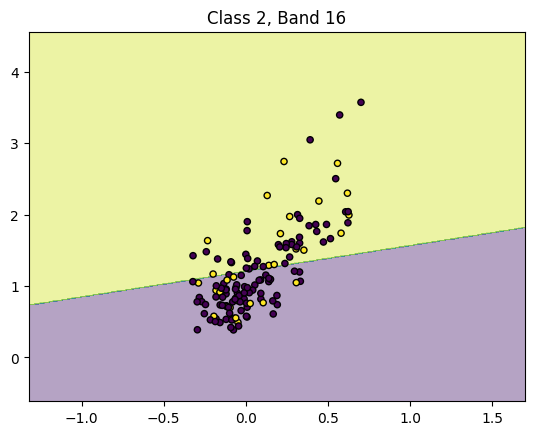

(175, 16, 401)
Classification Acc: 0.4857142857142857


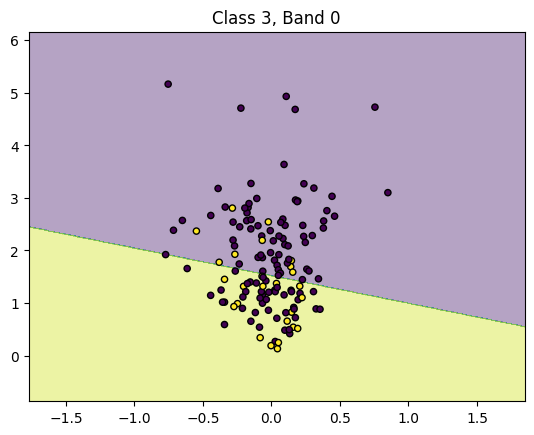

(175, 16, 401)
Classification Acc: 0.4


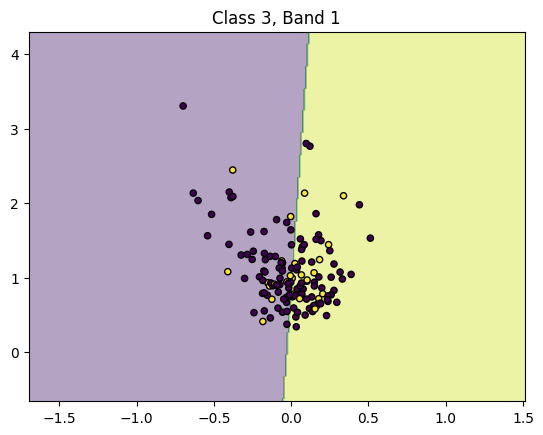

(175, 16, 401)
Classification Acc: 0.6


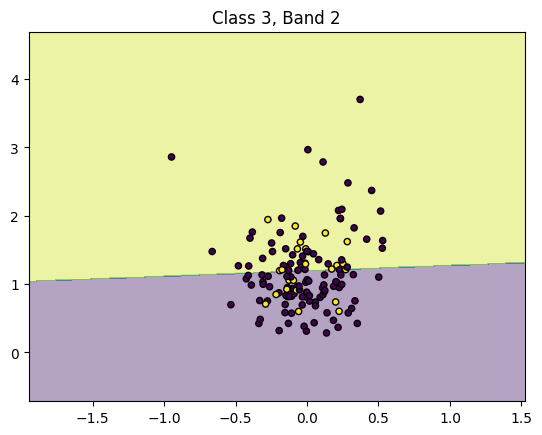

(175, 16, 401)
Classification Acc: 0.5714285714285714


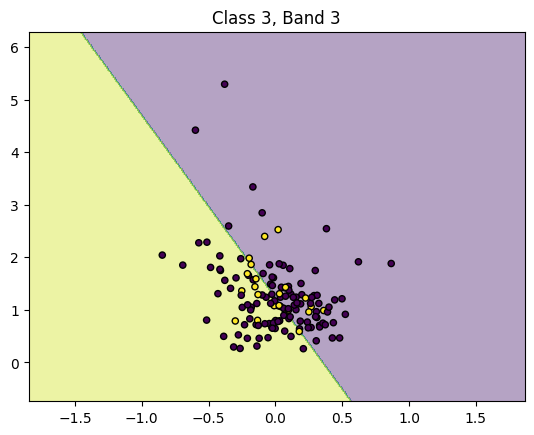

(175, 16, 401)
Classification Acc: 0.6


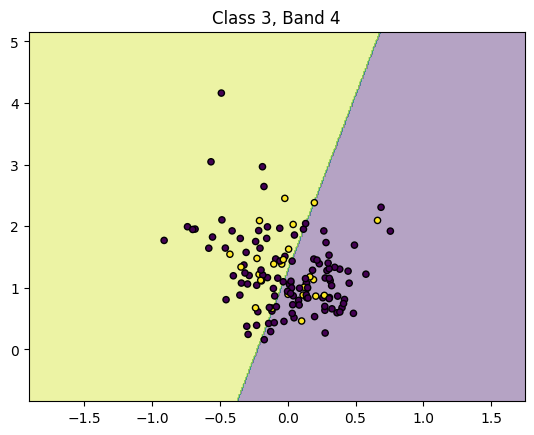

(175, 16, 401)
Classification Acc: 0.5714285714285714


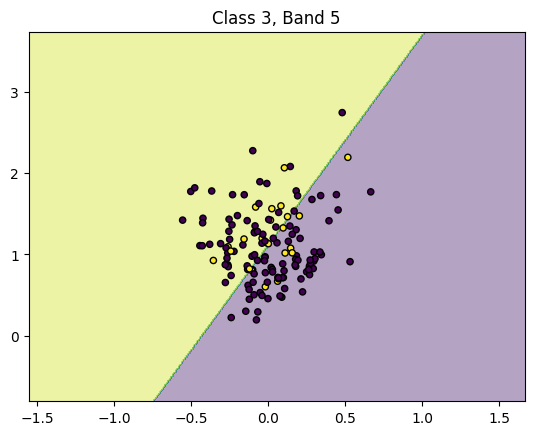

(175, 16, 401)
Classification Acc: 0.45714285714285713


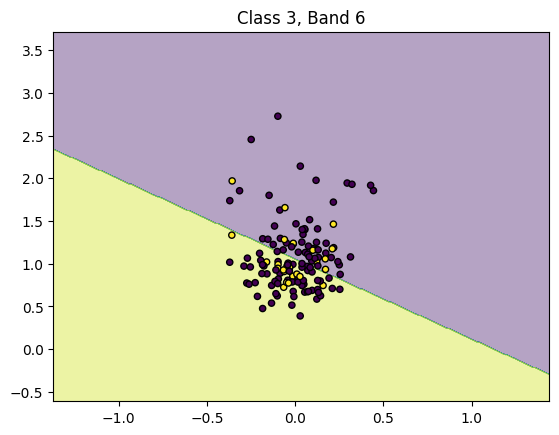

(175, 16, 401)
Classification Acc: 0.4857142857142857


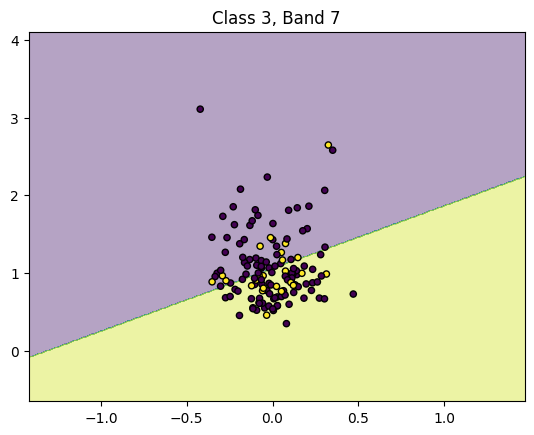

(175, 16, 401)
Classification Acc: 0.4857142857142857


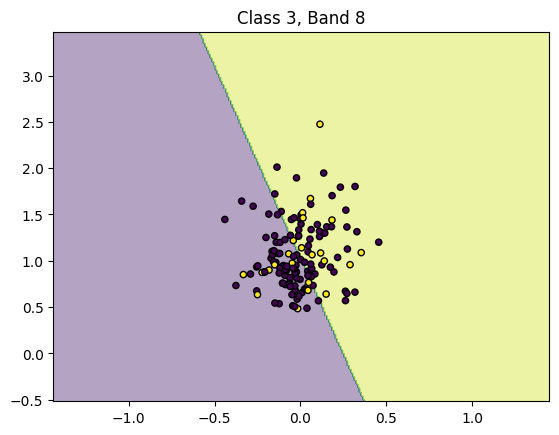

(175, 16, 401)
Classification Acc: 0.5428571428571428


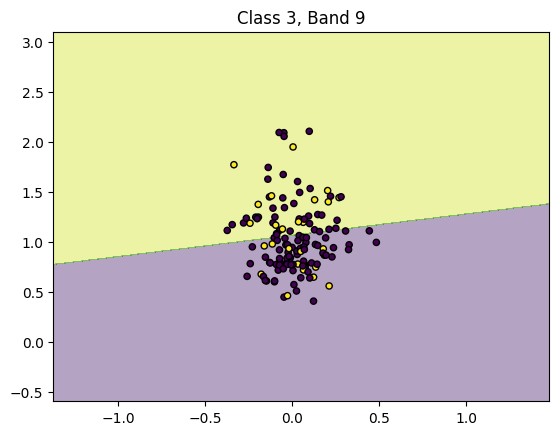

(175, 16, 401)
Classification Acc: 0.5714285714285714


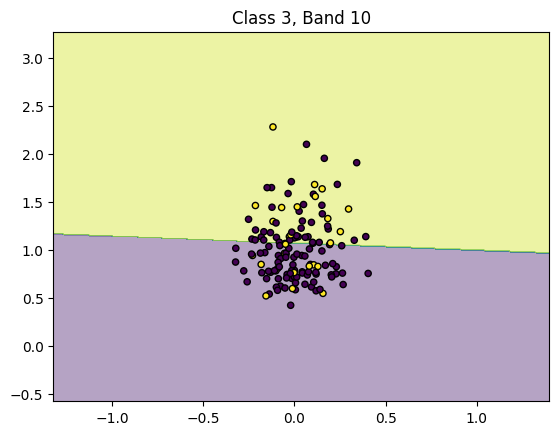

(175, 16, 401)
Classification Acc: 0.5428571428571428


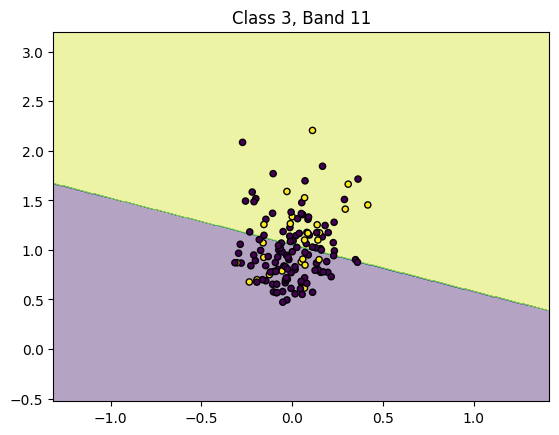

(175, 16, 401)
Classification Acc: 0.6285714285714286


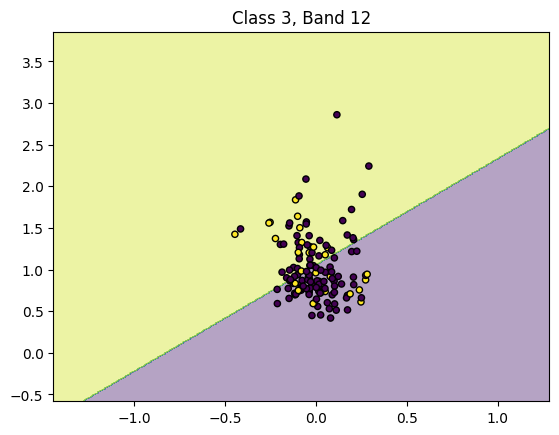

(175, 16, 401)
Classification Acc: 0.6857142857142857


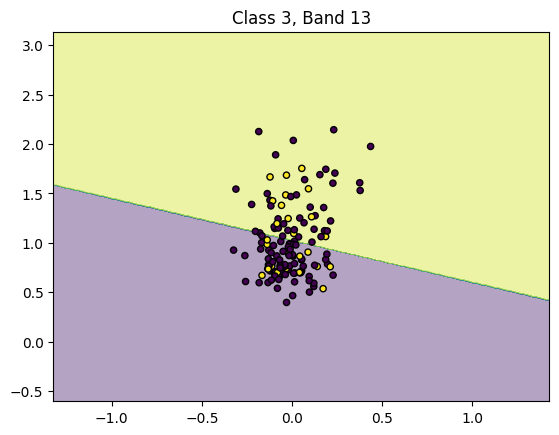

(175, 16, 401)
Classification Acc: 0.5142857142857142


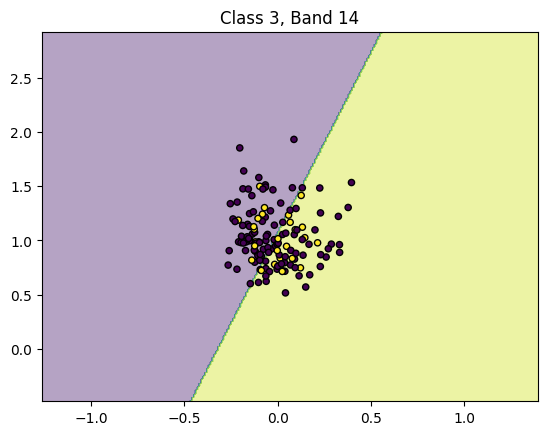

(175, 16, 401)
Classification Acc: 0.6285714285714286


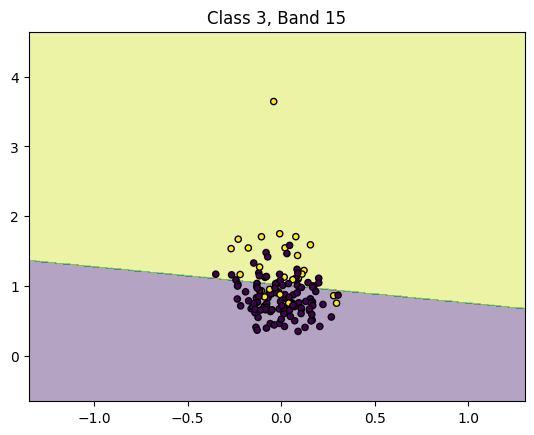

(175, 16, 401)
Classification Acc: 0.6571428571428571


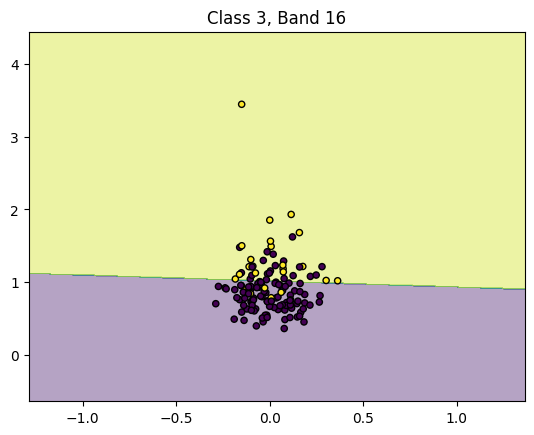

(175, 16, 401)
Classification Acc: 0.5142857142857142


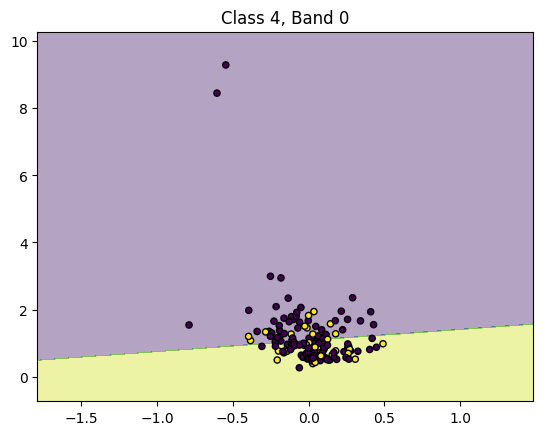

(175, 16, 401)
Classification Acc: 0.6857142857142857


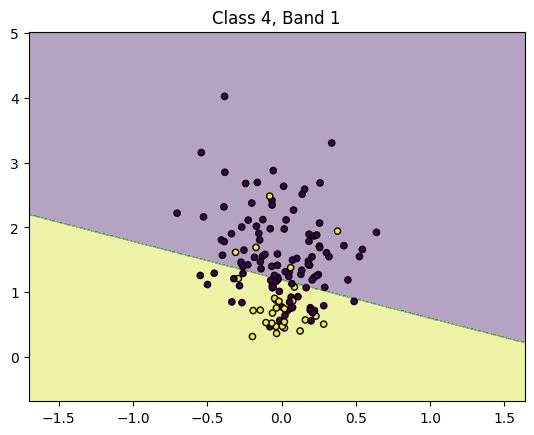

(175, 16, 401)
Classification Acc: 0.4857142857142857


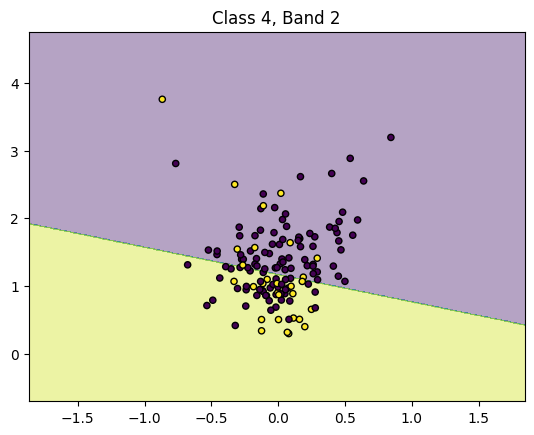

(175, 16, 401)
Classification Acc: 0.5428571428571428


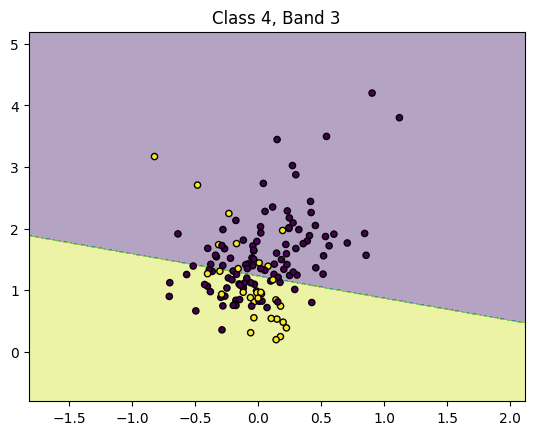

(175, 16, 401)
Classification Acc: 0.5714285714285714


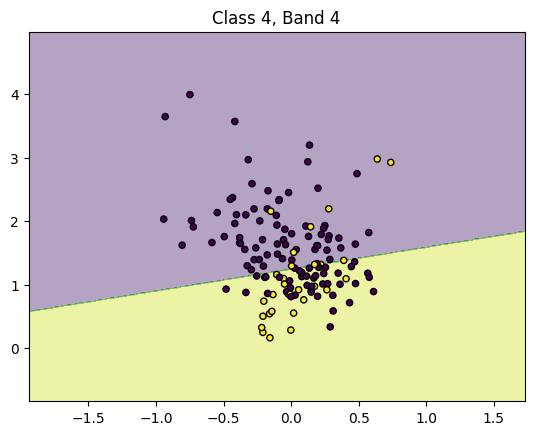

(175, 16, 401)
Classification Acc: 0.5142857142857142


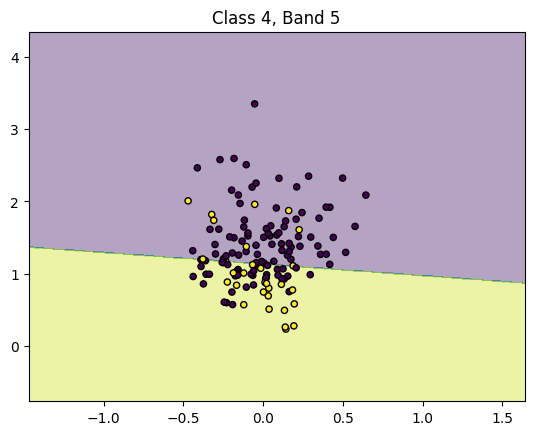

(175, 16, 401)
Classification Acc: 0.6857142857142857


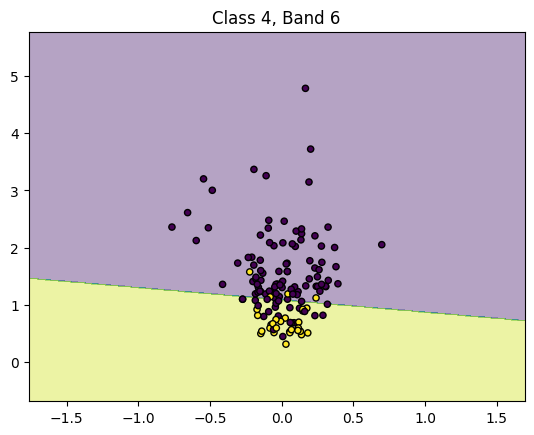

(175, 16, 401)
Classification Acc: 0.7428571428571429


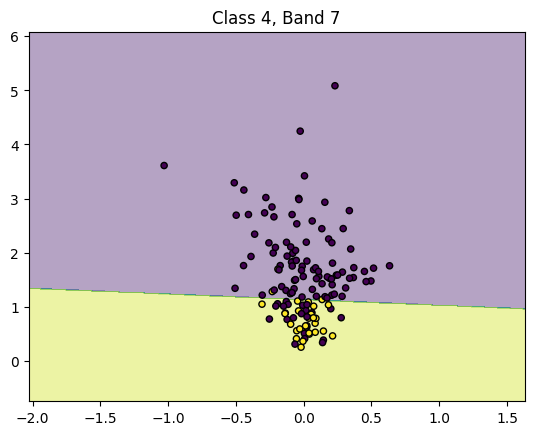

(175, 16, 401)
Classification Acc: 0.5714285714285714


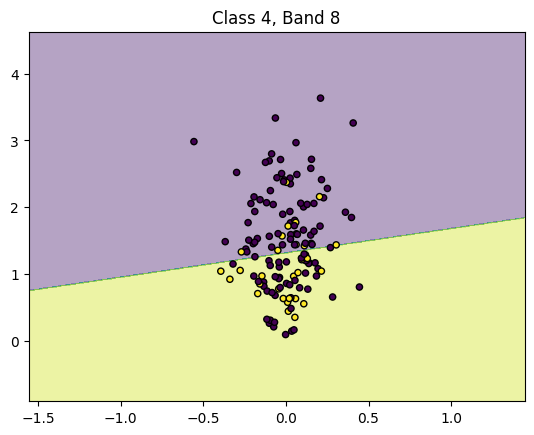

(175, 16, 401)
Classification Acc: 0.6571428571428571


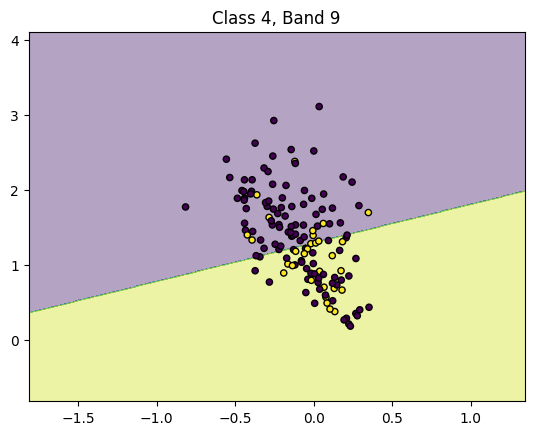

(175, 16, 401)
Classification Acc: 0.6571428571428571


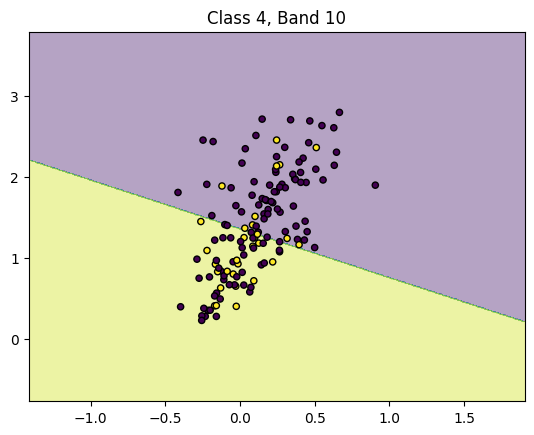

(175, 16, 401)
Classification Acc: 0.6


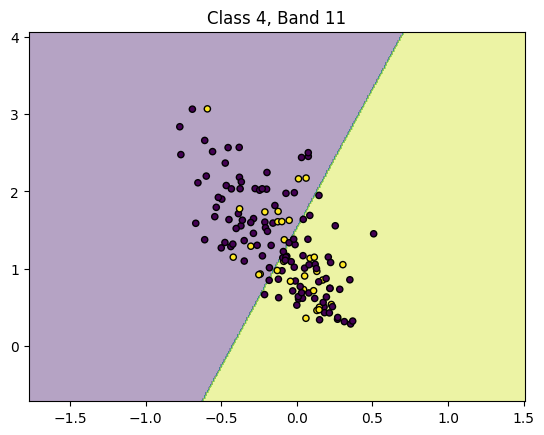

(175, 16, 401)
Classification Acc: 0.5428571428571428


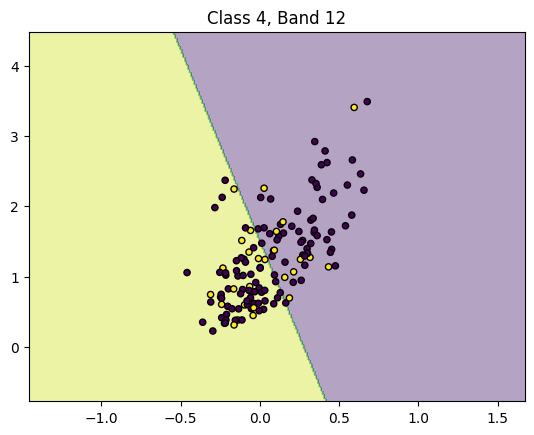

(175, 16, 401)
Classification Acc: 0.6


(175, 16, 401)
Classification Acc: 0.4857142857142857


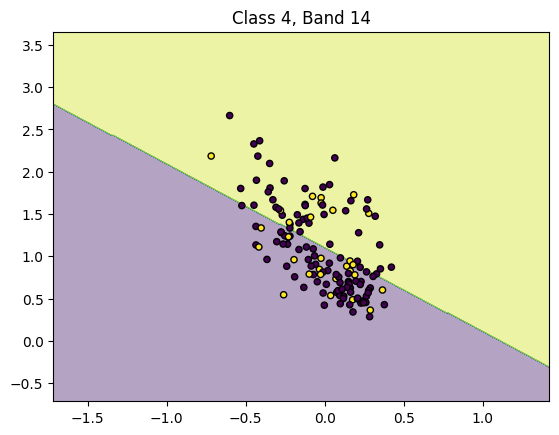

(175, 16, 401)
Classification Acc: 0.34285714285714286


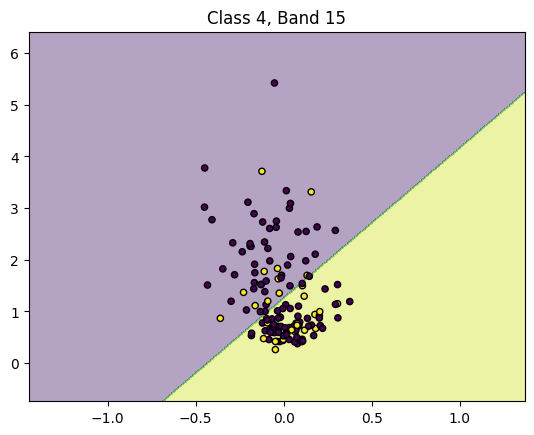

(175, 16, 401)
Classification Acc: 0.37142857142857144


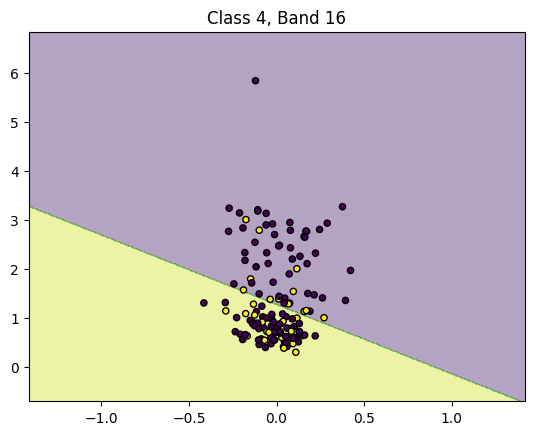

In [13]:
from sklearn.model_selection import train_test_split

X = all_train_data[subject]
print(X.shape)
# reshape to bands, trials, channels, samples
X = X.reshape(X.shape[0], X.shape[1]*X.shape[2], X.shape[3], X.shape[4])

#eliminate the timepoints on the edges
#X = X[:, :, :, 100:-50]

print(X.shape)


models = []

# create one vs all labels
for class_ in range(5):
    y = np.zeros(X.shape[1])
    y[class_*X.shape[1]//5:(class_+1)*X.shape[1]//5] = 1

    for band in range(len(bands)):
        X_band = X[band]
        print(X_band.shape)

        X_train, X_test, y_train, y_test = train_test_split(X_band, y, test_size=0.2, random_state=42)

        W = train_CSP(X_train, y_train, 2) #reduces dims to 2 CSP components

        X_CSP = apply_csp(X_train, W)
        X_test_CSP = apply_csp(X_test, W)
        
        model = fit_model(X_CSP, y_train, balance_classes=True)
        print("Classification Acc:", test_model(model, X_test_CSP, y_test))
        models.append([model, W])


        # plot decision boundary

        x_covs = np.array([np.cov(trial) for trial in X_CSP])
        x_means = np.mean(X_CSP, axis=(2))
        x_dataset = np.array([[x_covs[i][0][1]/x_covs[i][0][0], x_covs[i][1][1]/x_covs[i][0][0]] for i in range(X_CSP.shape[0])])

        x_min, x_max = x_dataset[:, 0].min() - 1, x_dataset[:, 0].max() + 1
        y_min, y_max = x_dataset[:, 1].min() - 1, x_dataset[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                            np.arange(y_min, y_max, 0.01))
        
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        plt.contourf(xx, yy, Z, alpha=0.4)
        plt.scatter(x_dataset[:, 0], x_dataset[:, 1], c=y_train, s=20, edgecolor='k')
        plt.title(f"Class {class_}, Band {band}")
        plt.show()



In [14]:
# train a model for all classes
y = np.array([i for i in range(5) for _ in range(X.shape[1]//5)])

def process_data_CSP_only(X, W):
    classifications = []

    for band in range(len(bands)):
        X_band = X[band]
        
        band_classifications = []
        for n in range(len(models)//len(bands)):
            model, W = models[n*len(bands) + band]
            model_classification = infer_model(model, apply_csp(X_band, W))
            band_classifications.append(model_classification)

        band_classifications = np.array(band_classifications).T
        classifications.append(band_classifications)

    classifications = np.array(classifications).reshape(X.shape[1], -1)



    

    print(classifications.shape)
    
    return classifications

def train_final_model(models, X, y):    
    classifications = process_data_CSP_only(X, models)
    
    print(classifications.shape)
    

    final_model = Perceptron(tol=1e-3, random_state=0)
    final_model.fit(classifications, y)
    print("Final model trained with accuracy: ", final_model.score(classifications, y))

    return final_model

def test_final_model(final_model, models, X, y):
    classifications = process_data_CSP_only(X, models)

    return final_model.score(classifications, y)

def infer_final_model(final_model, models, X):
    classifications = process_data_CSP_only(X, models)

    return final_model.predict(classifications)

#split data
X_train = []
X_test = []
y_train = []
y_test = []

for band in range(len(bands)):
    X_band = X[band]

    X_train_band, X_test_band, y_train_band, y_test_band = train_test_split(X_band, y, test_size=0.2, random_state=42)

    X_train.append(X_train_band)
    X_test.append(X_test_band)
    y_train.append(y_train_band)
    y_test.append(y_test_band)

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)[0]
y_test = np.array(y_test)[0]


final_model = train_final_model(models, X_train, y_train)
print(test_final_model(final_model, models, X_test, y_test))

(140, 85)
(140, 85)
Final model trained with accuracy:  0.8928571428571429
(35, 85)
0.2571428571428571


In [15]:
#try a random forest after csp classification
from sklearn.ensemble import RandomForestClassifier

def train_final_model(models, X, y):
    classifications = process_data_CSP_only(X, W)

    final_model = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
    final_model.fit(classifications, y)

    print("Final model trained with accuracy: ", final_model.score(classifications, y))

    return final_model

def test_final_model(final_model, models, X, y):
    classifications = process_data_CSP_only(X, W)

    return final_model.score(classifications, y)

def infer_final_model(final_model, models, X):
    classifications = process_data_CSP_only(X, W)

    return final_model.predict(classifications)

final_model = train_final_model(models, X_train, y_train)
print(test_final_model(final_model, models, X_test, y_test))

(140, 85)
Final model trained with accuracy:  0.4928571428571429
(35, 85)
0.02857142857142857


Layers:  (1, 1)
(140, 85)
Final model trained with accuracy:  0.18571428571428572
(35, 85)
0.2571428571428571 (1, 1)
(35, 85)
Layers:  (1, 2)
(140, 85)
Final model trained with accuracy:  0.2714285714285714
(35, 85)
0.05714285714285714 (1, 2)
(35, 85)
Layers:  (1, 3)
(140, 85)


c:\Users\tomas\Desktop\Trabalho\FEUP\Neuro\Project\eegaming\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Final model trained with accuracy:  0.5071428571428571
(35, 85)
0.17142857142857143 (1, 3)
(35, 85)
Layers:  (2, 1)
(140, 85)


c:\Users\tomas\Desktop\Trabalho\FEUP\Neuro\Project\eegaming\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Final model trained with accuracy:  0.36428571428571427
(35, 85)
0.11428571428571428 (2, 1)
(35, 85)
Layers:  (2, 2)
(140, 85)


c:\Users\tomas\Desktop\Trabalho\FEUP\Neuro\Project\eegaming\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Final model trained with accuracy:  0.7
(35, 85)
0.17142857142857143 (2, 2)
(35, 85)
Layers:  (2, 3)
(140, 85)


c:\Users\tomas\Desktop\Trabalho\FEUP\Neuro\Project\eegaming\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Final model trained with accuracy:  0.3357142857142857
(35, 85)
0.17142857142857143 (2, 3)
(35, 85)
Layers:  (3, 1)
(140, 85)


c:\Users\tomas\Desktop\Trabalho\FEUP\Neuro\Project\eegaming\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Final model trained with accuracy:  0.5428571428571428
(35, 85)
0.17142857142857143 (3, 1)
(35, 85)
Layers:  (3, 2)
(140, 85)


c:\Users\tomas\Desktop\Trabalho\FEUP\Neuro\Project\eegaming\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Final model trained with accuracy:  0.7428571428571429
(35, 85)
0.14285714285714285 (3, 2)
(35, 85)
Layers:  (3, 3)
(140, 85)


c:\Users\tomas\Desktop\Trabalho\FEUP\Neuro\Project\eegaming\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Final model trained with accuracy:  0.5571428571428572
(35, 85)
0.11428571428571428 (3, 3)
(35, 85)


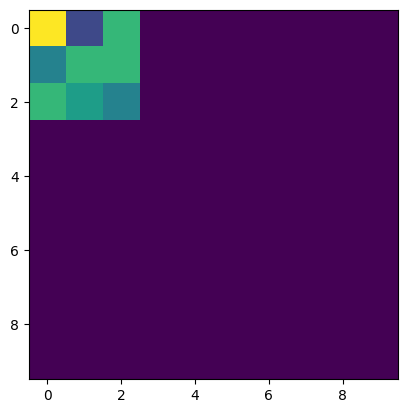

In [16]:
# try a neural network
from sklearn.neural_network import MLPClassifier

def train_final_model(models, X, y, layers = (5, 3)):
    classifications = process_data_CSP_only(X, W)

    final_model = MLPClassifier(random_state=1, max_iter=1000, hidden_layer_sizes=layers)
    final_model.fit(classifications, y)

    print("Final model trained with accuracy: ", final_model.score(classifications, y))

    return final_model

def test_final_model(final_model, models, X, y):
    classifications = process_data_CSP_only(X, W)

    return final_model.score(classifications, y)

def infer_final_model(final_model, models, X):
    classifications = process_data_CSP_only(X, W)

    return final_model.predict(classifications)

accs = np.zeros((10, 10))

for l1 in range(3):
    for l2 in range(3):
        layers = (l1+1, l2+1)
        print("Layers: ", layers)
        final_model = train_final_model(models, X_train, y_train, layers)
        print(test_final_model(final_model, models, X_test, y_test), layers)
        accs[l1, l2] = test_final_model(final_model, models, X_test, y_test)

# tested from 1 to 10 neurons for l1 and l2. 3, 3 and 7, 10 were the best, but only at 34% accuracy

plt.imshow(accs)
plt.show()

In [20]:
def process_data_with_distributions(X, models):
    dataset = []

    for band in range(len(bands)):
        X_band = X[band]
        
        band_classifications = []
        for n in range(len(models)//len(bands)):
            model, W = models[n*len(bands) + band]
            # model_classification = infer_model(model, apply_csp(X_band, W))
            # model_classification = np.expand_dims(model_classification, axis=1)
            
            mean_dataset = np.mean(apply_csp(X_band, W), axis=(2))
            cov_dataset = np.array([np.cov(trial) for trial in apply_csp(X_band, W)])

            cov_dataset = [[cov_dataset[i][0][1], cov_dataset[i][0][0], cov_dataset[i][1][1]] for i in range(X_band.shape[0])]
            cov_dataset = np.array(cov_dataset)

            band_classifications.append(np.concatenate([mean_dataset, cov_dataset], axis=1))
        
        dataset.append(np.array(band_classifications))
    
    dataset = np.array(dataset)
    dataset = dataset.reshape(X.shape[1], -1)
    print(dataset.shape)


    return dataset

In [21]:
# try random forest with distributions
def train_final_model(models, X, y):
    dataset = process_data_with_distributions(X, models)

    final_model = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
    final_model.fit(dataset, y)

    print("Final model trained with accuracy: ", final_model.score(dataset, y))

    return final_model

def test_final_model(final_model, models, X, y):
    dataset = process_data_with_distributions(X, models)

    return final_model.score(dataset, y)

def infer_final_model(final_model, models, X):
    dataset = process_data_with_distributions(X, models)

    return final_model.predict(dataset)

final_model = train_final_model(models, X_train, y_train)
print(test_final_model(final_model, models, X_test, y_test))

(140, 425)
Final model trained with accuracy:  0.7642857142857142
(35, 425)
0.08571428571428572


In [22]:
# try a neural network
from sklearn.neural_network import MLPClassifier

def train_final_model(models, X, y, layers = (6)):
    dataset = process_data_with_distributions(X, models)

    final_model = MLPClassifier(random_state=1, max_iter=5000, hidden_layer_sizes=layers)
    final_model.fit(dataset, y)

    print("Final model trained with accuracy: ", final_model.score(dataset, y))

    return final_model

def test_final_model(final_model, models, X, y):    
        dataset = process_data_with_distributions(X, models)
    
        return final_model.score(dataset, y)

def infer_final_model(final_model, models, X):
    dataset = process_data_with_distributions(X, models)

    return final_model.predict(dataset)

for l1 in range(1, 5):
    for l2 in range(1, 5):
        for l3 in range(1, 3):
            layers = (l1+1, l2+1, l3+1)
            print("Layers: ", layers)
            final_model = train_final_model(models, X_train, y_train, layers)
            print(layers, test_final_model(final_model, models, X_test, y_test))

Layers:  (2, 2, 2)
(140, 425)
Final model trained with accuracy:  0.17857142857142858
(35, 425)
(2, 2, 2) 0.2857142857142857
Layers:  (2, 2, 3)
(140, 425)
Final model trained with accuracy:  0.2357142857142857
(35, 425)
(2, 2, 3) 0.05714285714285714
Layers:  (2, 2, 4)
(140, 425)
Final model trained with accuracy:  0.21428571428571427
(35, 425)
(2, 2, 4) 0.14285714285714285
Layers:  (2, 2, 5)
(140, 425)
Final model trained with accuracy:  0.17857142857142858
(35, 425)
(2, 2, 5) 0.2857142857142857
Layers:  (2, 2, 6)
(140, 425)
Final model trained with accuracy:  0.17857142857142858
(35, 425)
(2, 2, 6) 0.2857142857142857
Layers:  (2, 2, 7)
(140, 425)
Final model trained with accuracy:  0.2357142857142857
(35, 425)
(2, 2, 7) 0.05714285714285714
Layers:  (2, 2, 8)
(140, 425)
Final model trained with accuracy:  0.21428571428571427
(35, 425)
(2, 2, 8) 0.14285714285714285
Layers:  (2, 3, 2)
(140, 425)
Final model trained with accuracy:  0.17857142857142858
(35, 425)
(2, 3, 2) 0.285714285714285

KeyboardInterrupt: 

In [24]:
test_accs = np.zeros((20,20))

for l1 in range(8):
    for l2 in range(8):
        layers = (l1+1, l2+1)
        print("Layers: ", layers)
        final_model = train_final_model(models, X_train, y_train, layers)
        test_accs[l1, l2] = test_final_model(final_model, models, X_test, y_test)

plt.imshow(test_accs)
plt.show()

Layers:  (1, 1)
(140, 425)
Final model trained with accuracy:  0.2357142857142857
(35, 425)
Layers:  (1, 2)
(140, 425)
Final model trained with accuracy:  0.21428571428571427
(35, 425)
Layers:  (1, 3)
(140, 425)
Final model trained with accuracy:  0.2357142857142857
(35, 425)
Layers:  (1, 4)
(140, 425)
Final model trained with accuracy:  0.2357142857142857
(35, 425)
Layers:  (1, 5)
(140, 425)
Final model trained with accuracy:  0.2357142857142857
(35, 425)
Layers:  (1, 6)
(140, 425)
Final model trained with accuracy:  0.2357142857142857
(35, 425)
Layers:  (1, 7)
(140, 425)
Final model trained with accuracy:  0.18571428571428572
(35, 425)
Layers:  (1, 8)
(140, 425)
Final model trained with accuracy:  0.2357142857142857
(35, 425)
Layers:  (2, 1)
(140, 425)
Final model trained with accuracy:  0.21428571428571427
(35, 425)
Layers:  (2, 2)
(140, 425)
Final model trained with accuracy:  0.18571428571428572
(35, 425)
Layers:  (2, 3)
(140, 425)
Final model trained with accuracy:  0.18571428571

In [31]:
layers = (50,30, 30)
print("Layers: ", layers)
final_model = train_final_model(models, X_train, y_train, layers)
print(test_final_model(final_model, models, X_test, y_test))

Layers:  (50, 30, 30)
(140, 425)
Final model trained with accuracy:  0.2357142857142857
(35, 425)
0.05714285714285714
